In [202]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [204]:
# load the data from the xlsx file
from pathlib import Path

input_path = Path("../lc-project-data")
output_path = Path("../lc-project-data")

# for MP, 
# input_path = Path("../Data/Original Data/2024_04_26")
# output_path = Path("../Data/DataV3")

fn = "FINAL-CORRECTED-DATA-2024-04-26.xlsx"

# fn = "/Users/david/projects/lc2-1028/2024-08-02-data-timeseries.xlsx"

df = pd.read_excel(input_path / fn)
print(f"Dataframe shape: {df.shape}")

Dataframe shape: (5664, 692)


In [205]:
# drop the last row which is a set of totals
df = df.drop(df.index[-1])

df.shape

(5663, 692)

In [206]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = df.copy()
preserved_df.shape

(5663, 692)

In [207]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [208]:
df = preserved_df

In [209]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Columns: 692 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](7), float64(655), int64(10), object(20)
memory usage: 29.9+ MB


In [210]:
# A list of columns to drop
to_drop = []

In [211]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [212]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                148
MALE                   64
Male                    4
TRANSGENDER FEMALE      1
Name: count, dtype: int64
Nulls = 5446


In [213]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# info on the adjunctive columns
print(preserved_df[adj_cols].info())
print(preserved_df[adj_cols].describe())
print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adjunctive___1   3366 non-null   float64
 1   adjunctive___2   3362 non-null   float64
 2   adjunctive___3   3253 non-null   float64
 3   adjunctive___4   3253 non-null   float64
 4   adjunctive___5   3253 non-null   float64
 5   adjunctive___6   3253 non-null   float64
 6   adjunctive___7   3253 non-null   float64
 7   adjunctive___8   3253 non-null   float64
 8   adjunctive___9   3253 non-null   float64
 9   adjunctive___10  3253 non-null   float64
dtypes: float64(10)
memory usage: 442.6 KB
None
       adjunctive___1  adjunctive___2  adjunctive___3  adjunctive___4  \
count     3366.000000     3362.000000          3253.0          3253.0   
mean         0.032086        0.000297             0.0             0.0   
std          0.176254        0.017247             0.0             0.0   
m

In [214]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 33 columns


['other_hhx4',
 'other_hhx5',
 'other_hhx6',
 'other_hhx7',
 'other_hhx8',
 'other_hhx9',
 'other_hhx10',
 'medication8',
 'medication9',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [215]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(5663, 659)

In [216]:
# get all column names
df_columns = df.columns

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [217]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15,]
unk = [99]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')
UNK    = df.query('participant_type in @unk')

# df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC' if x in hc_vals else 'UNKNOWN')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG     3367
LC_POS     2193
HC           82
UNKNOWN      21
Name: count, dtype: int64

In [218]:
pd.crosstab(df.dag, df.LC_STATUS).rename(index=site_name_dict)

LC_STATUS,HC,LC_NEG,LC_POS,UNKNOWN
dag,,,,
LDN,32,177,110,0
MTL,0,1997,895,21
SAN,3,71,265,0
RIO,9,128,651,0
LUS,38,994,272,0


In [219]:
pd.crosstab(df.dag, df.LC_STATUS,normalize='index').rename(index=site_name_dict).round(2)

LC_STATUS,HC,LC_NEG,LC_POS,UNKNOWN
dag,,,,
LDN,0.10,0.55,0.34,0.00
MTL,0.00,0.69,0.31,0.01
SAN,0.01,0.21,0.78,0.00
RIO,0.01,0.16,0.83,0.00
LUS,0.03,0.76,0.21,0.00


## DEMOGRAPHICS
- apr 27 - LUS increase in missing data for HCP and MICRO w apr 26 data

In [220]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5663, 5)

In [221]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     5613 non-null   float64
 1   age     5619 non-null   float64
 2   hcp     3289 non-null   float64
 3   micro   3162 non-null   float64
 4   dag     5663 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 221.3 KB


In [222]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,1,49
age,1,0,0,1,42
hcp,80,148,224,734,1188
micro,90,158,227,768,1258
dag,0,0,0,0,0


In [223]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_67142/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(5663, 3)

In [224]:
demographic_features

,sex,age,dag
0,2.0,30.0,2
1,1.0,33.0,2
2,2.0,36.0,2
3,2.0,50.0,2
4,1.0,40.0,2
...,...,...,...
5658,1.0,50.0,3
5659,1.0,48.0,3
5660,2.0,42.0,3
5661,1.0,23.0,3


### EXPLORE: PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [225]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS,UNKNOWN
participant_type,,,,
1,0,7,0,0
2,0,0,74,0
3,38,0,0,0
4,0,0,238,0
5,0,328,0,0
6,0,0,1672,0
7,0,1886,0,0
8,0,0,83,0
10,0,1146,0,0


In [226]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'dag', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

dag,1,2,3,4,5
participant_type,,,,,
1,2,0,0,0,5
2,33,0,38,0,3
3,0,0,0,0,38
4,0,238,0,0,0
5,0,328,0,0,0
6,77,574,227,651,143
7,175,523,71,128,989
8,0,83,0,0,0
10,0,1146,0,0,0


### EXPLORE: Patient IDs


In [227]:
df.loc[145]

record_id                                        353
sex                                              2.0
age                                             36.0
home_location                                    1.0
living_with                                      1.0
                                       ...          
datetime_freezing                                NaN
aliquots                                         NaN
biospecimen_collection_not    10664 Volume/Notes 500
biospecimen_complete                               2
LC_STATUS                                    UNKNOWN
Name: 145, Length: 660, dtype: object

In [228]:
# export the list of record_ids for the LC_POSITIVE cases
LC_pos_record_ids = df.query('participant_type in @pos_vals')['record_id']

# output to a dataset
LC_pos_record_ids.to_csv(output_path / "LC_POSITIVE_RECORD_IDS.csv", index = True)


### EXPLORE: SITES

- summary of LC status by site
- not a feature set
- information only

In [229]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,HC,LC_NEG,LC_POS,UNKNOWN
dag,,,,
LDN,32,177,110,0
MTL,0,1997,895,21
SAN,3,71,265,0
RIO,9,128,651,0
LUS,38,994,272,0


In [230]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    2913
LUS    1304
RIO     788
SAN     339
LDN     319
Name: count, dtype: int64

In [231]:
# # get the range of indices for each site
# site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

# site_ranges.sort_values()

## SUBSTANCE USE

In [232]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]
substance_features.shape

(5663, 5)

In [233]:
# how many nulls per site?
print("Missing SUBSTANCE values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCE values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1258
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1258
substances___5,81,0,0,121,0


In [234]:

# ==============================================================================
# 2024-04-29
# ==============================================================================
# fill the missing values with zero, per email discussion 2024-04-28?
# Q: is this valid? Asked via email Apr 29

substance_features = substance_features.fillna(0)

In [235]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      0.0      0.0      0.0      0.0
 1      0.0      0.0      0.0      0.0      0.0
 2      0.0      0.0      0.0      0.0      0.0
 3      1.0      0.0      0.0      0.0      0.0
 4      0.0      0.0      0.0      0.0      0.0,
 (5663, 5))

In [236]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1258
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1258
substances___5,81,0,0,121,0


In [237]:
# how many nulls per site?
print("Missing SUBSTANCES values by site and status:")
df.groupby(['dag','LC_STATUS'])[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site and status:


dag            LDN                  MTL                SAN               RIO  \
LC_STATUS       HC LC_NEG LC_POS LC_NEG LC_POS UNKNOWN  HC LC_NEG LC_POS  HC   
substances___1   0      4     77      0      0       0   0      0      0   0   
substances___2   0      4     77      0      0       0   0      0      0   0   
substances___3   0      4     77   1997    895      21   0      0      0   0   
substances___4   0      4     77      0      0       0   0      0      0   0   
substances___5   0      4     77      0      0       0   0      0      0   0   

dag                          LUS                
LC_STATUS      LC_NEG LC_POS  HC LC_NEG LC_POS  
substances___1      0      0   0      0      0  
substances___2    121      0   0    989    269  
substances___3    121      0   0      0      0  
substances___4    121      0   0    989    269  
substances___5    121      0   0      0      0

In [238]:
substance_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SUBST-1  5663 non-null   float64
 1   SUBST-2  5663 non-null   float64
 2   SUBST-3  5663 non-null   float64
 3   SUBST-4  5663 non-null   float64
 4   SUBST-5  5663 non-null   float64
dtypes: float64(5)
memory usage: 221.3 KB


## MEDICATIONS
 - one hot encode

In [239]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1',
 'medication2',
 'medication3',
 'medication4',
 'medication5',
 'medication6',
 'medication7',
 'medication10']

In [240]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [241]:
# how many nulls per site?
print("Missing MEDS values by site:")
df.groupby('dag')[MEDTEMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing MEDS values by site:


dag,LDN,MTL,SAN,RIO,LUS
medication1,186,2913,276,735,713
medication2,280,2913,313,778,1073
medication3,299,2913,330,786,1264
medication4,306,2913,335,785,1297
medication5,316,2913,336,788,1304
medication6,318,2913,338,787,1304
medication7,319,2913,338,787,1304
medication10,319,2913,338,788,1304


In [242]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      28 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    20 columns
(5663, 28)


In [243]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

In [244]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
medication_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MED-Analgesics                         5663 non-null   int64
 1   MED-Anesthetics                        5663 non-null   int64
 2   MED-Antibacterials                     5663 non-null   int64
 3   MED-Anticonvulsants                    5663 non-null   int64
 4   MED-Antidepressants                    5663 non-null   int64
 5   MED-Antifungals                        5663 non-null   int64
 6   MED-Antimigraine-agents                5663 non-null   int64
 7   MED-Antiparasitics                     5663 non-null   int64
 8   MED-Antiparkinson-agents               5663 non-null   int64
 9   MED-Antipsychotics                     5663 non-null   int64
 10  MED-Antispasticity-agents              5663 non-null   int64
 11  MED-Antivirals                

## HEALTH HISTORY

### HHX - Patient History

In [246]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [247]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [248]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,26,655,96,43,497
past_hhx___2,1,17,4,0,0
past_hhx___3,17,193,45,0,73
past_hhx___4,22,344,86,22,183
past_hhx___5,9,232,19,2,7
past_hhx___6,7,141,7,0,8
past_hhx___7,6,105,12,0,8
past_hhx___8,5,136,15,0,6
past_hhx___9,1,15,0,0,0
past_hhx___10,1,75,9,1,1


In [250]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,60,0,0,0,0
past_hhx___2,81,0,0,121,1258
past_hhx___3,74,0,0,121,0
past_hhx___4,66,0,0,0,0
past_hhx___5,76,0,0,0,0
past_hhx___6,80,0,0,121,0
past_hhx___7,76,0,0,121,0
past_hhx___8,81,0,0,0,0
past_hhx___9,81,0,0,0,1258
past_hhx___10,81,0,0,0,0


### HHX-OTHER - One-hot encode `other_hhx`


In [251]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx11', 'other_hhx2', 'other_hhx3']

In [252]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index


In [253]:
# how many nulls per site?
print("Missing OTHER-HHX values by site:")
df.groupby('dag')[OTHER_HHX_TEMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER-HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
other_hhx,273,2202,258,782,1297
other_hhx11,310,2851,324,788,1304
other_hhx2,318,2904,338,788,1304
other_hhx3,319,2912,339,788,1304


In [254]:

# NOTE THAT WE ARE FILLING NANS WITH ZERO HERE
# ASSUMPTION: if it's not reported, it's not present
a = df[OTHER_HHX_TEMP].fillna(0).values
# a = df[OTHER_HHX_TEMP]

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [255]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-DVT,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,...,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-fatigue,HHX-OTHER-surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [256]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-DVT,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0


### Concatenate health history

In [257]:
# concatenate the health hx features with the other health hx features

# sort hhx_df columns
hhx_df = hhx_df.reindex(sorted(hhx_df.columns), axis=1) # type: ignore

# sort other_hhx_features columns
other_hhx_features = other_hhx_features.reindex(sorted(other_hhx_features.columns), axis=1)

# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [258]:
#==============================================================================
# 2024-04-28
# In keeping with issues #1, #4, etc., - assume that if it's not reported, it wasn't volunteered by px, nor was it identified by physician/interviewer
# therefore, fill nans with zero
#==============================================================================
# 2024-04-29
# Discussed with DDF via SMS. Patient hx was taken from charts and interviews - should not be blank. Therefore fill with zero
#==============================================================================
hx_features_all = hx_features_all.fillna(0)

In [259]:
# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
# print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


Text(0.5, 1.0, 'Health History Features')

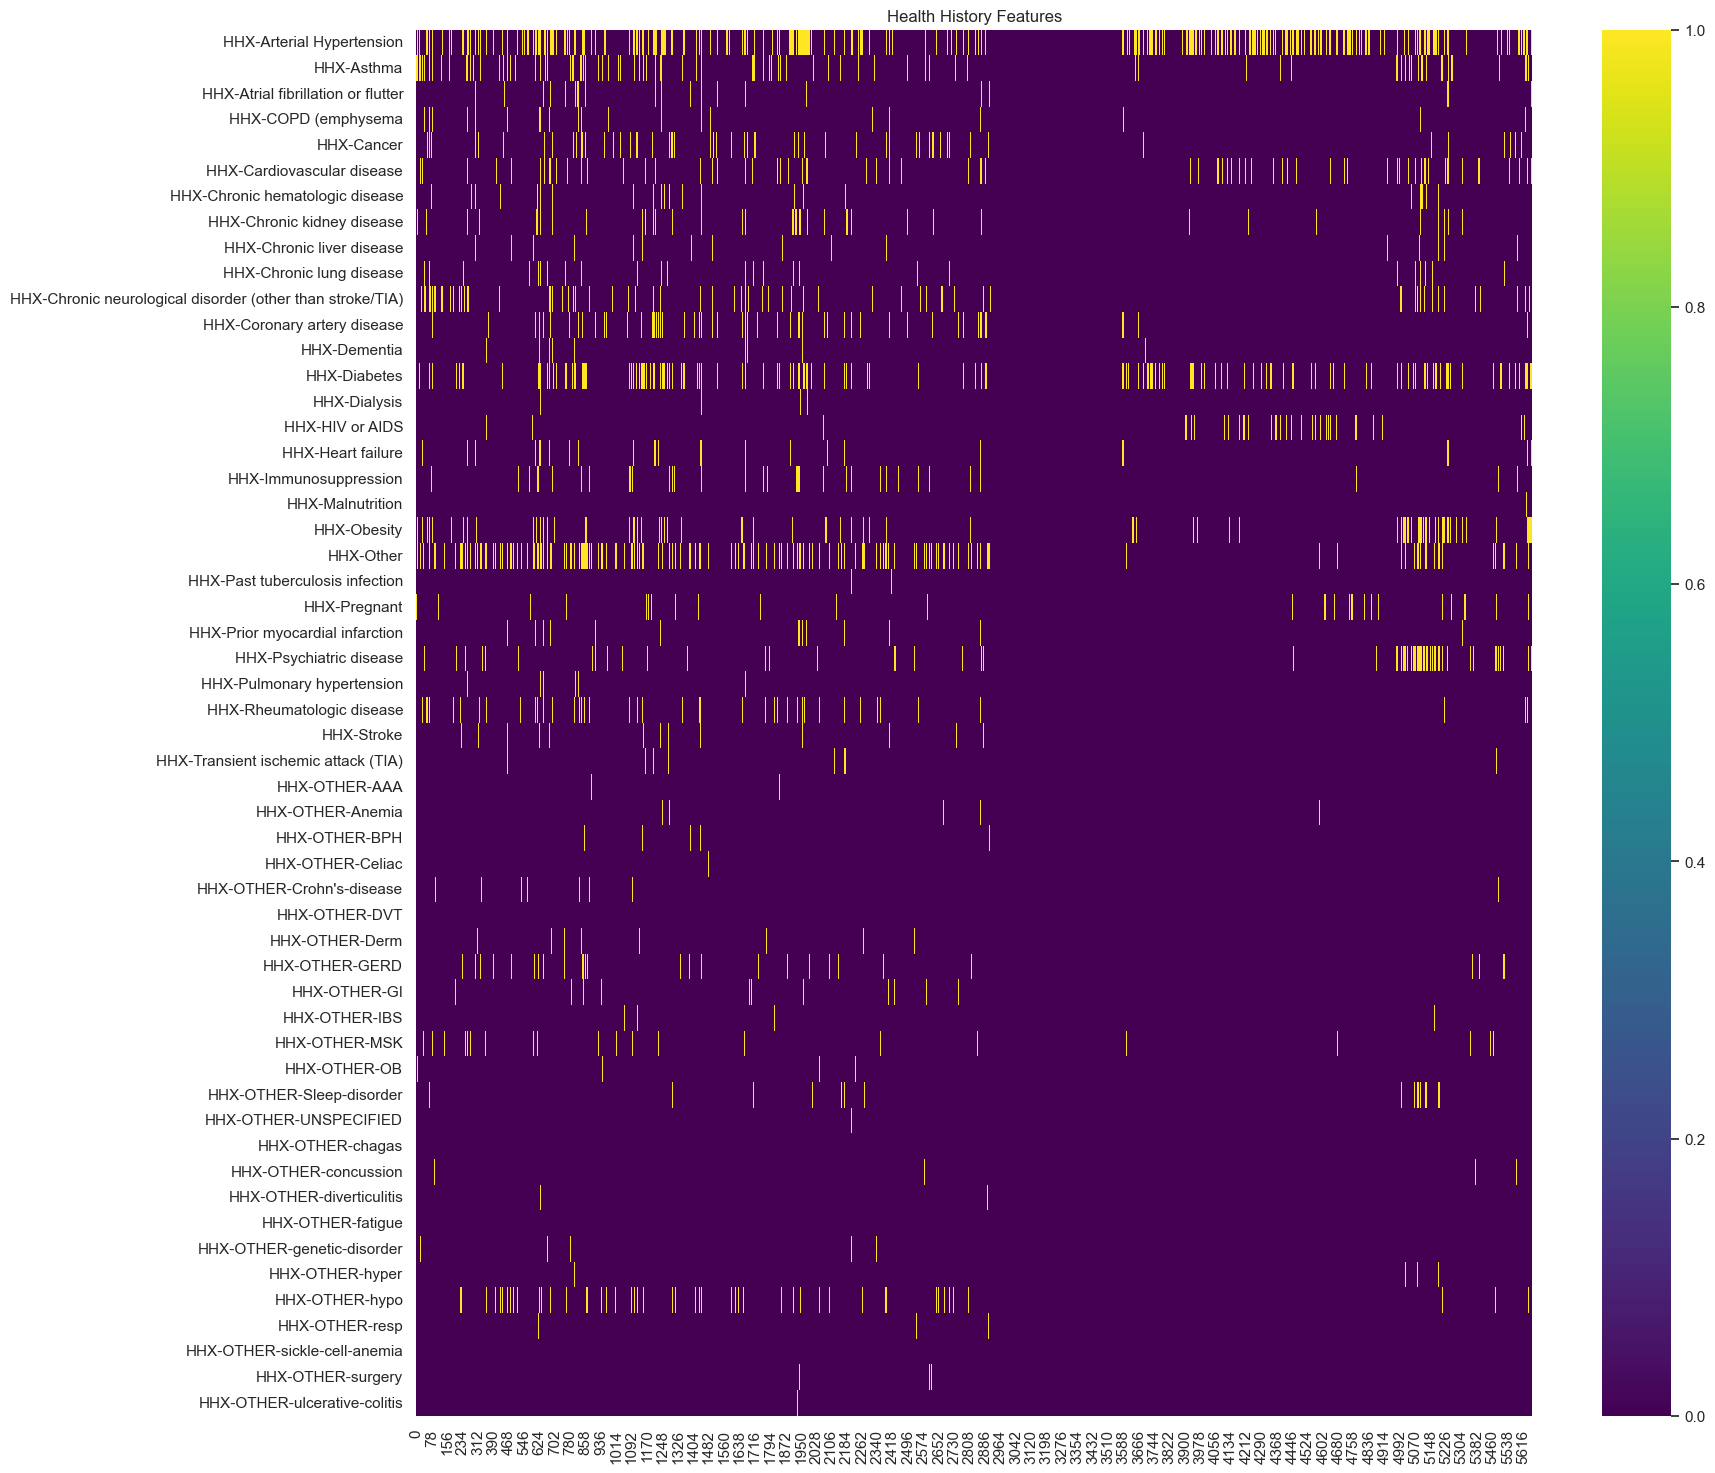

In [260]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SURVEYS

In [261]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col if "complete" not in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
# it's scooped up in the above line
# GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
# these columns were intermedaries and are not useful in the analysis, so we don't need these
# PHX_COMPLETE    = ["phx_complete"]
# PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
# PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

# the set of survey columns
SURVEYS = GAD + PROMIS + PHQ

In [262]:
survey_features = df[SURVEYS]
survey_features.shape

# how many missing values?

# print("Missing SURVEY values by site:")
# df.groupby('dag')[SURVEYS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

(5663, 47)

In [263]:
# # plot it as a heatmap
# fig, ax = plt.subplots(figsize=(6,6))
# sns.heatmap(survey_features.T, cbar=True, ax = ax, cmap = 'viridis')

In [264]:
### CONCLUSION:
# - survey featureas are mostly missing, so we will not use them in the larger dataset


## SYMPTOMS

In [265]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



<Axes: >

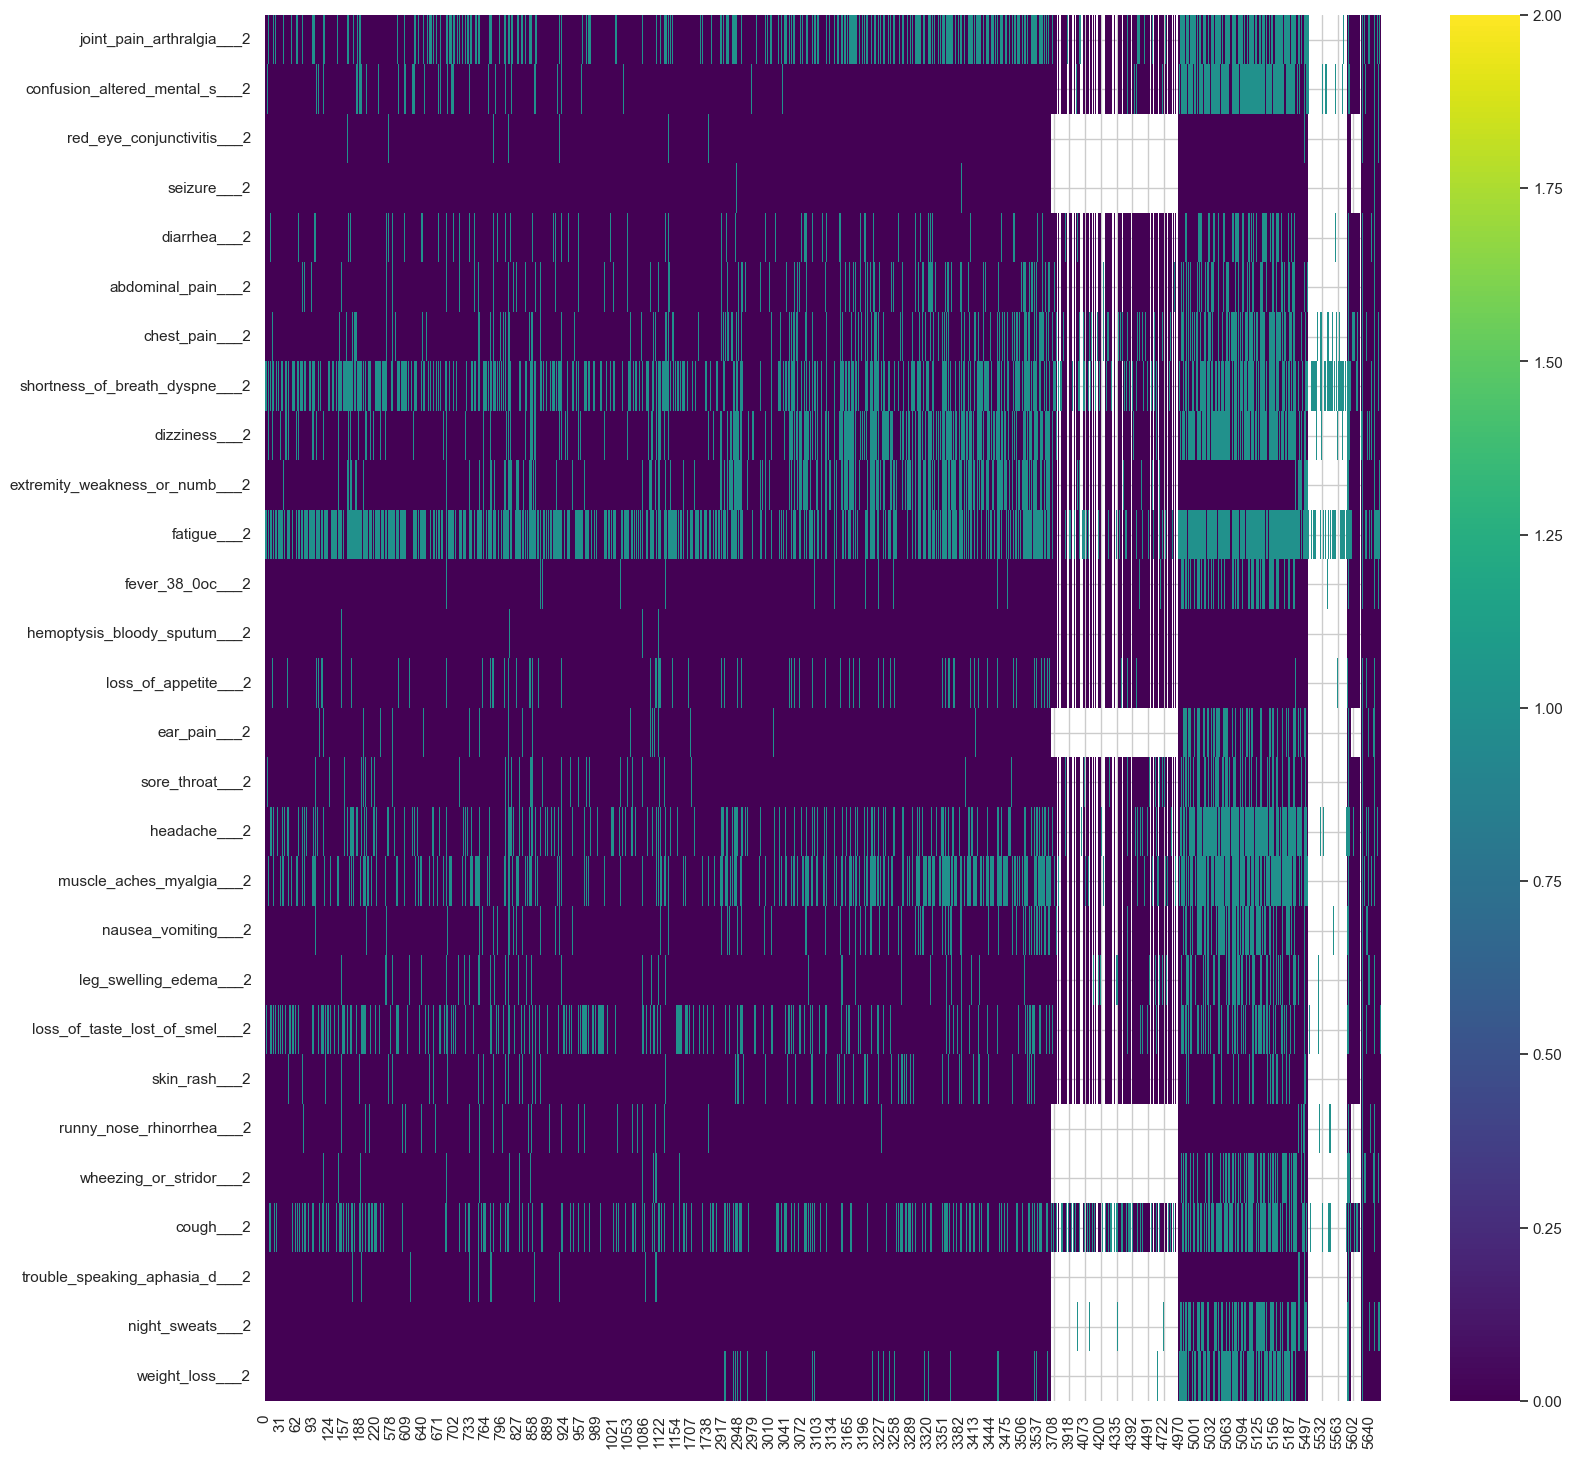

In [266]:
# heatmap showing missing values
fig, ax = plt.subplots(figsize=(18,18))

# only features ending in ___2
ss1 = symptom_features.filter(like = "___2", axis = 1)

# find indices of LC_POSITIVE cases
lc_pos_indices = df.query('participant_type in @pos_vals').index

ss1 = ss1.loc[lc_pos_indices]

sns.heatmap(ss1.T, cbar=True, ax = ax, cmap = 'viridis')

In [267]:


# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# ANSWER: per MP's email of 2024-04-28, we should assume that no response is equivalent to a "no" and encode as zero

symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1) # type: ignore

symptom_features.shape

(5663, 56)

In [268]:
# how many records per site?
site_counts = df['dag'].value_counts().rename(index = site_name_dict)
site_counts

dag
MTL    2913
LUS    1304
RIO     788
SAN     339
LDN     319
Name: count, dtype: int64

In [269]:
# how many non-null values per site?

print("NOT MISSING SYMPTOMS values by site:")
df.groupby('dag')[SYMP].apply(lambda x: x.notnull().sum()).rename(index = site_name_dict).T

vv = df.groupby('dag')[SYMP].apply(lambda x: x.notnull().sum()).rename(index = site_name_dict).T

# select only items with index ending in ___2

vvv = vv.loc[[col for col in vv.index if col.endswith("___2")]]
vvv



NOT MISSING SYMPTOMS values by site:


dag,LDN,MTL,SAN,RIO,LUS
joint_pain_arthralgia___2,241,2913,339,667,546
confusion_altered_mental_s___2,253,2913,339,667,544
red_eye_conjunctivitis___2,238,2913,339,667,46
seizure___2,238,2913,339,667,46
diarrhea___2,239,2913,339,667,545
abdominal_pain___2,238,2913,339,667,547
chest_pain___2,260,2913,339,667,551
shortness_of_breath_dyspne___2,289,2913,339,667,554
dizziness___2,244,2913,339,667,548
extremity_weakness_or_numb___2,238,2913,339,667,546


In [270]:
ww = [[0.5,0.2,0.3,0.4,0.1],
              [0.5,0.8,0.7,0.6,0.9]]
ww

[[0.5, 0.2, 0.3, 0.4, 0.1], [0.5, 0.8, 0.7, 0.6, 0.9]]

In [271]:
# convert ww to a dataframe
ww_df = pd.DataFrame(ww, columns = site_counts.index)

vv = np.array(vv)

# take the dot product of vv and ww
vv.dot(ww_df.T)


array([[1200.5, 4260.5],
       [1126.2, 3579.8],
       [1205. , 4265. ],
       [1132. , 3584. ],
       [1074.7, 3128.3],
       [1074.7, 3128.3],
       [1074.7, 3128.3],
       [1074.7, 3128.3],
       [1250.4, 4334.6],
       [1125.1, 3577.9],
       [1251.4, 4335.6],
       [1124.8, 3579.2],
       [1262.4, 4346.6],
       [1136.2, 3593.8],
       [1280.9, 4365.1],
       [1151. , 3611. ],
       [1200.5, 4260.5],
       [1127.9, 3583.1],
       [1200.5, 4260.5],
       [1124.7, 3578.3],
       [1206.5, 4266.5],
       [1144.2, 3605.8],
       [1279.9, 4364.1],
       [1125. , 3577. ],
       [1200.5, 4260.5],
       [1124.5, 3576.5],
       [1201. , 4261. ],
       [1125. , 3577. ],
       [1074.7, 3128.3],
       [1074.8, 3129.2],
       [1205. , 4265. ],
       [1126.2, 3579.8],
       [1273.4, 4357.6],
       [1130.1, 3586.9],
       [1273.9, 4358.1],
       [1126.2, 3583.8],
       [1251.4, 4335.6],
       [1125. , 3577. ],
       [1125.7, 3587.3],
       [1126.2, 3579.8],


In [272]:
vv

array([[ 238, 2913,  339,  667, 1304],
       [ 241, 2913,  339,  667,  546],
       [ 247, 2913,  339,  667, 1304],
       [ 253, 2913,  339,  667,  544],
       [ 238, 2913,  339,  667,   46],
       [ 238, 2913,  339,  667,   46],
       [ 238, 2913,  339,  667,   46],
       [ 238, 2913,  339,  667,   46],
       [ 241, 2913,  339,  788, 1304],
       [ 239, 2913,  339,  667,  545],
       [ 243, 2913,  339,  788, 1304],
       [ 238, 2913,  339,  667,  547],
       [ 265, 2913,  339,  788, 1304],
       [ 260, 2913,  339,  667,  551],
       [ 302, 2913,  339,  788, 1304],
       [ 289, 2913,  339,  667,  554],
       [ 238, 2913,  339,  667, 1304],
       [ 244, 2913,  339,  667,  548],
       [ 238, 2913,  339,  667, 1304],
       [ 238, 2913,  339,  667,  546],
       [ 250, 2913,  339,  667, 1304],
       [ 275, 2913,  339,  667,  556],
       [ 300, 2913,  339,  788, 1304],
       [ 239, 2913,  339,  667,  544],
       [ 238, 2913,  339,  667, 1304],
       [ 238, 2913,  339,

In [273]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing SYMPTOM values by site:


dag,LDN,MTL,SAN,RIO,LUS
joint_pain_arthralgia___1,81,0,0,121,0
joint_pain_arthralgia___2,78,0,0,121,758
confusion_altered_mental_s___1,72,0,0,121,0
confusion_altered_mental_s___2,66,0,0,121,760
red_eye_conjunctivitis___1,81,0,0,121,1258
red_eye_conjunctivitis___2,81,0,0,121,1258
seizure___1,81,0,0,121,1258
seizure___2,81,0,0,121,1258
diarrhea___1,78,0,0,0,0
diarrhea___2,80,0,0,121,759


In [274]:
site_counts

dag
MTL    2913
LUS    1304
RIO     788
SAN     339
LDN     319
Name: count, dtype: int64

In [275]:

# divide the missing counts by the total number of records per site
print("Fraction of missing SYMPTOM values by site:")

missing_symptoms = df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

missing_symptoms = missing_symptoms.div(site_counts, axis = 1)

# weighting factor per symptom per site
missing_symptoms = 1/(1 - missing_symptoms)

# prepend each symptom with SYMP-
missing_symptoms.index = [f"SYMPT-{c}" for c in missing_symptoms.index]

# retain only items ending in ___2
missing_symptoms = missing_symptoms.loc[[col for col in missing_symptoms.index if col.endswith("___2")]]

missing_symptoms

# export this to a json file
missing_symptoms.to_json(Path("./JSON") / "EXPERIMENTAL-missing-symptoms.json")


Fraction of missing SYMPTOM values by site:


In [276]:
missing_symptoms

dag,LDN,LUS,MTL,RIO,SAN
SYMPT-joint_pain_arthralgia___2,1.323651,2.388278,1.0,1.181409,1.0
SYMPT-confusion_altered_mental_s___2,1.260870,2.397059,1.0,1.181409,1.0
SYMPT-red_eye_conjunctivitis___2,1.340336,28.347826,1.0,1.181409,1.0
SYMPT-seizure___2,1.340336,28.347826,1.0,1.181409,1.0
SYMPT-diarrhea___2,1.334728,2.392661,1.0,1.181409,1.0
SYMPT-abdominal_pain___2,1.340336,2.383912,1.0,1.181409,1.0
SYMPT-chest_pain___2,1.226923,2.366606,1.0,1.181409,1.0
SYMPT-shortness_of_breath_dyspne___2,1.103806,2.353791,1.0,1.181409,1.0
SYMPT-dizziness___2,1.307377,2.379562,1.0,1.181409,1.0
SYMPT-extremity_weakness_or_numb___2,1.340336,2.388278,1.0,1.181409,1.0


In [277]:
# sort the columns so that they appear in the same order as the site_name_dict
missing_symptoms = missing_symptoms[site_name_dict.values()]

Text(0.5, 1.0, 'Fraction of Missing SYMPTOM values by site')

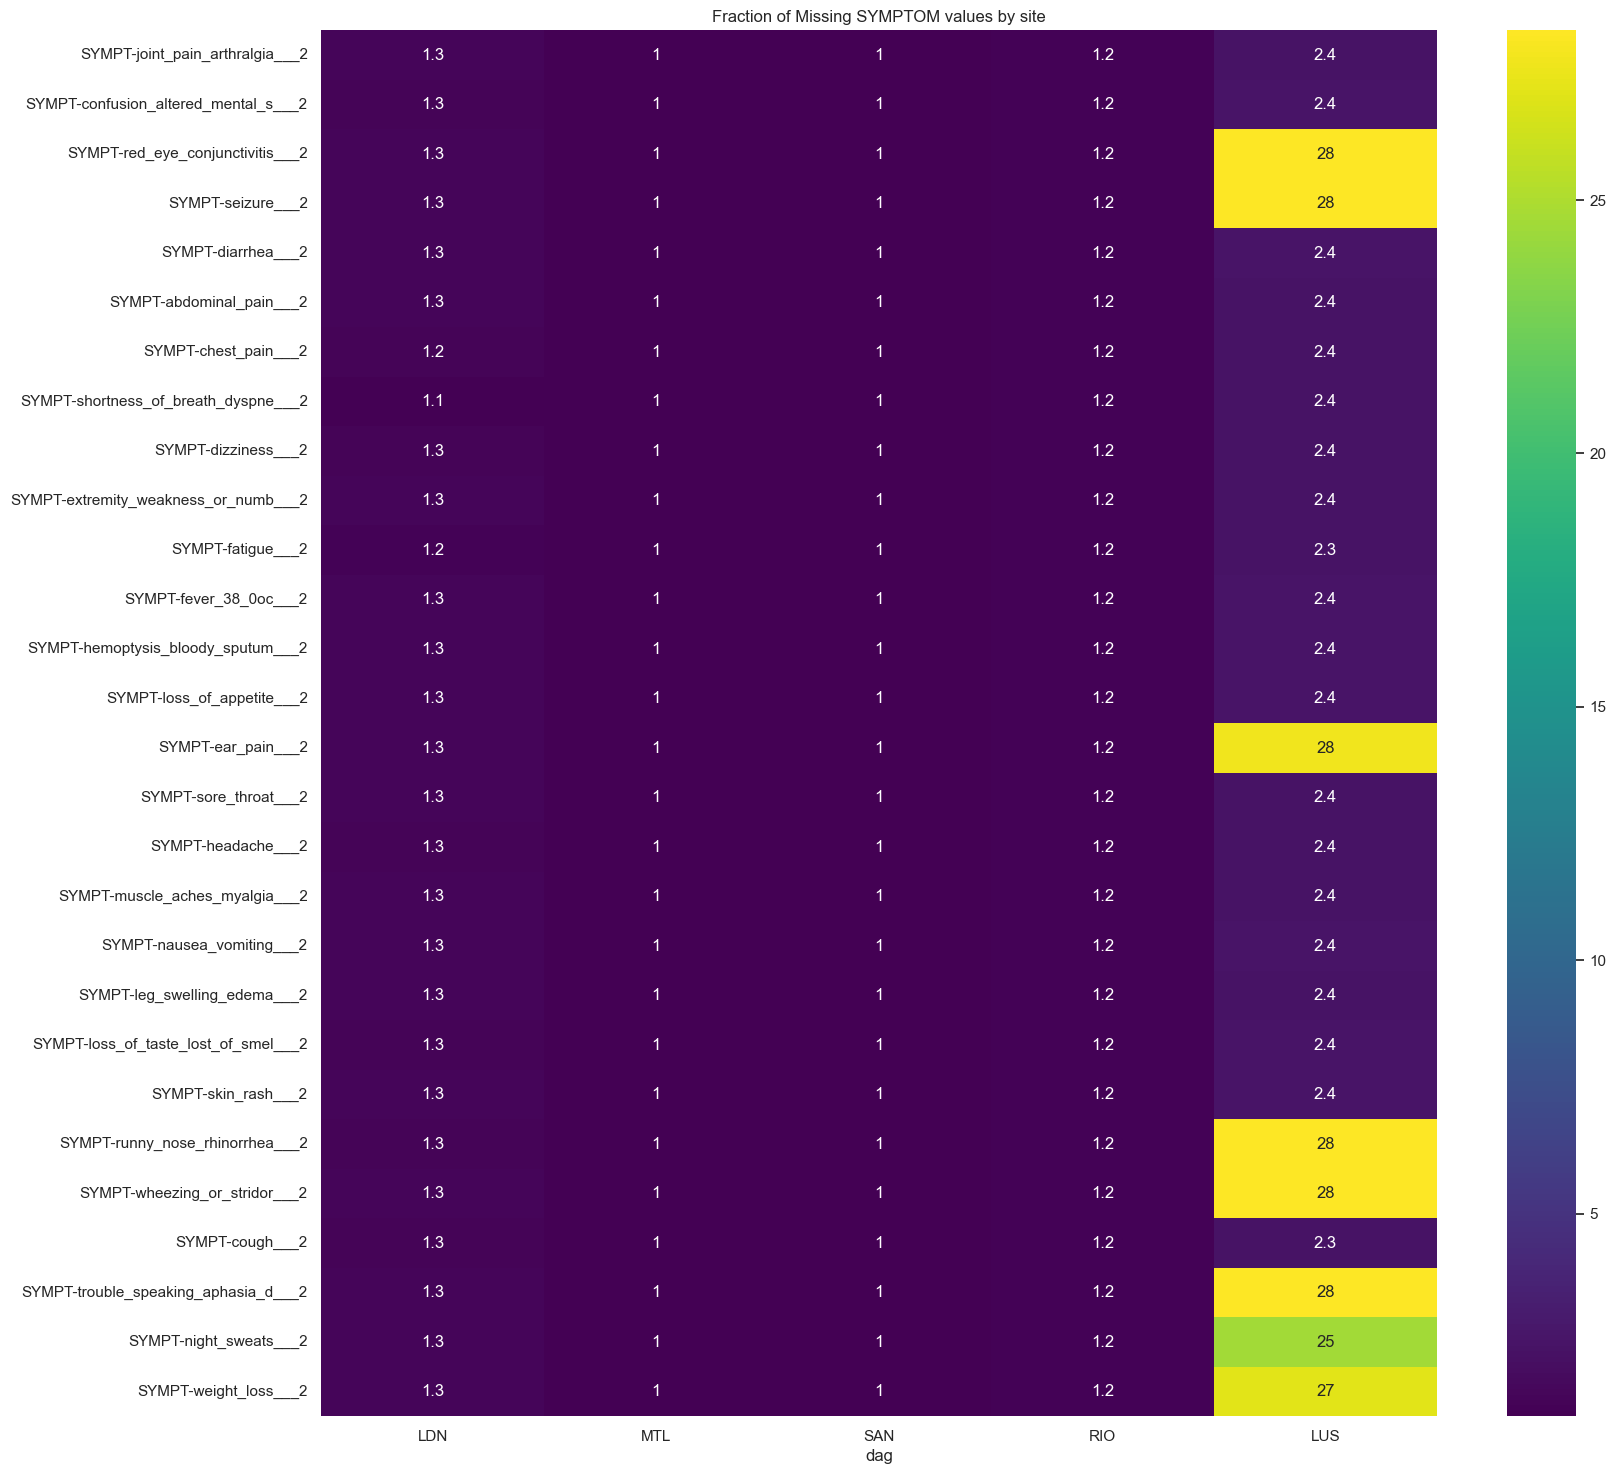

In [278]:
fig, ax = plt.subplots(figsize=(18,18))

sns.heatmap(missing_symptoms, cmap = 'viridis', annot = True, ax =ax)
plt.title("Fraction of Missing SYMPTOM values by site")

In [279]:
# runny_nose_rhinorrhea___1
item = "runny_nose_rhinorrhea___1"
item = "red_eye_conjunctivitis___1"

df.groupby('dag')[item].sum().rename(index = site_name_dict).T / df.groupby('dag')[item].count().rename(index = site_name_dict).T, df.groupby('dag')[item].sum().rename(index = site_name_dict).T, df.groupby('dag')[item].count().rename(index = site_name_dict).T


(dag
 LDN    0.033613
 MTL    0.013732
 SAN    0.070796
 RIO    0.000000
 LUS    0.043478
 Name: red_eye_conjunctivitis___1, dtype: float64,
 dag
 LDN     8.0
 MTL    40.0
 SAN    24.0
 RIO     0.0
 LUS     2.0
 Name: red_eye_conjunctivitis___1, dtype: float64,
 dag
 LDN     238
 MTL    2913
 SAN     339
 RIO     667
 LUS      46
 Name: red_eye_conjunctivitis___1, dtype: int64)

<Axes: xlabel='dag'>

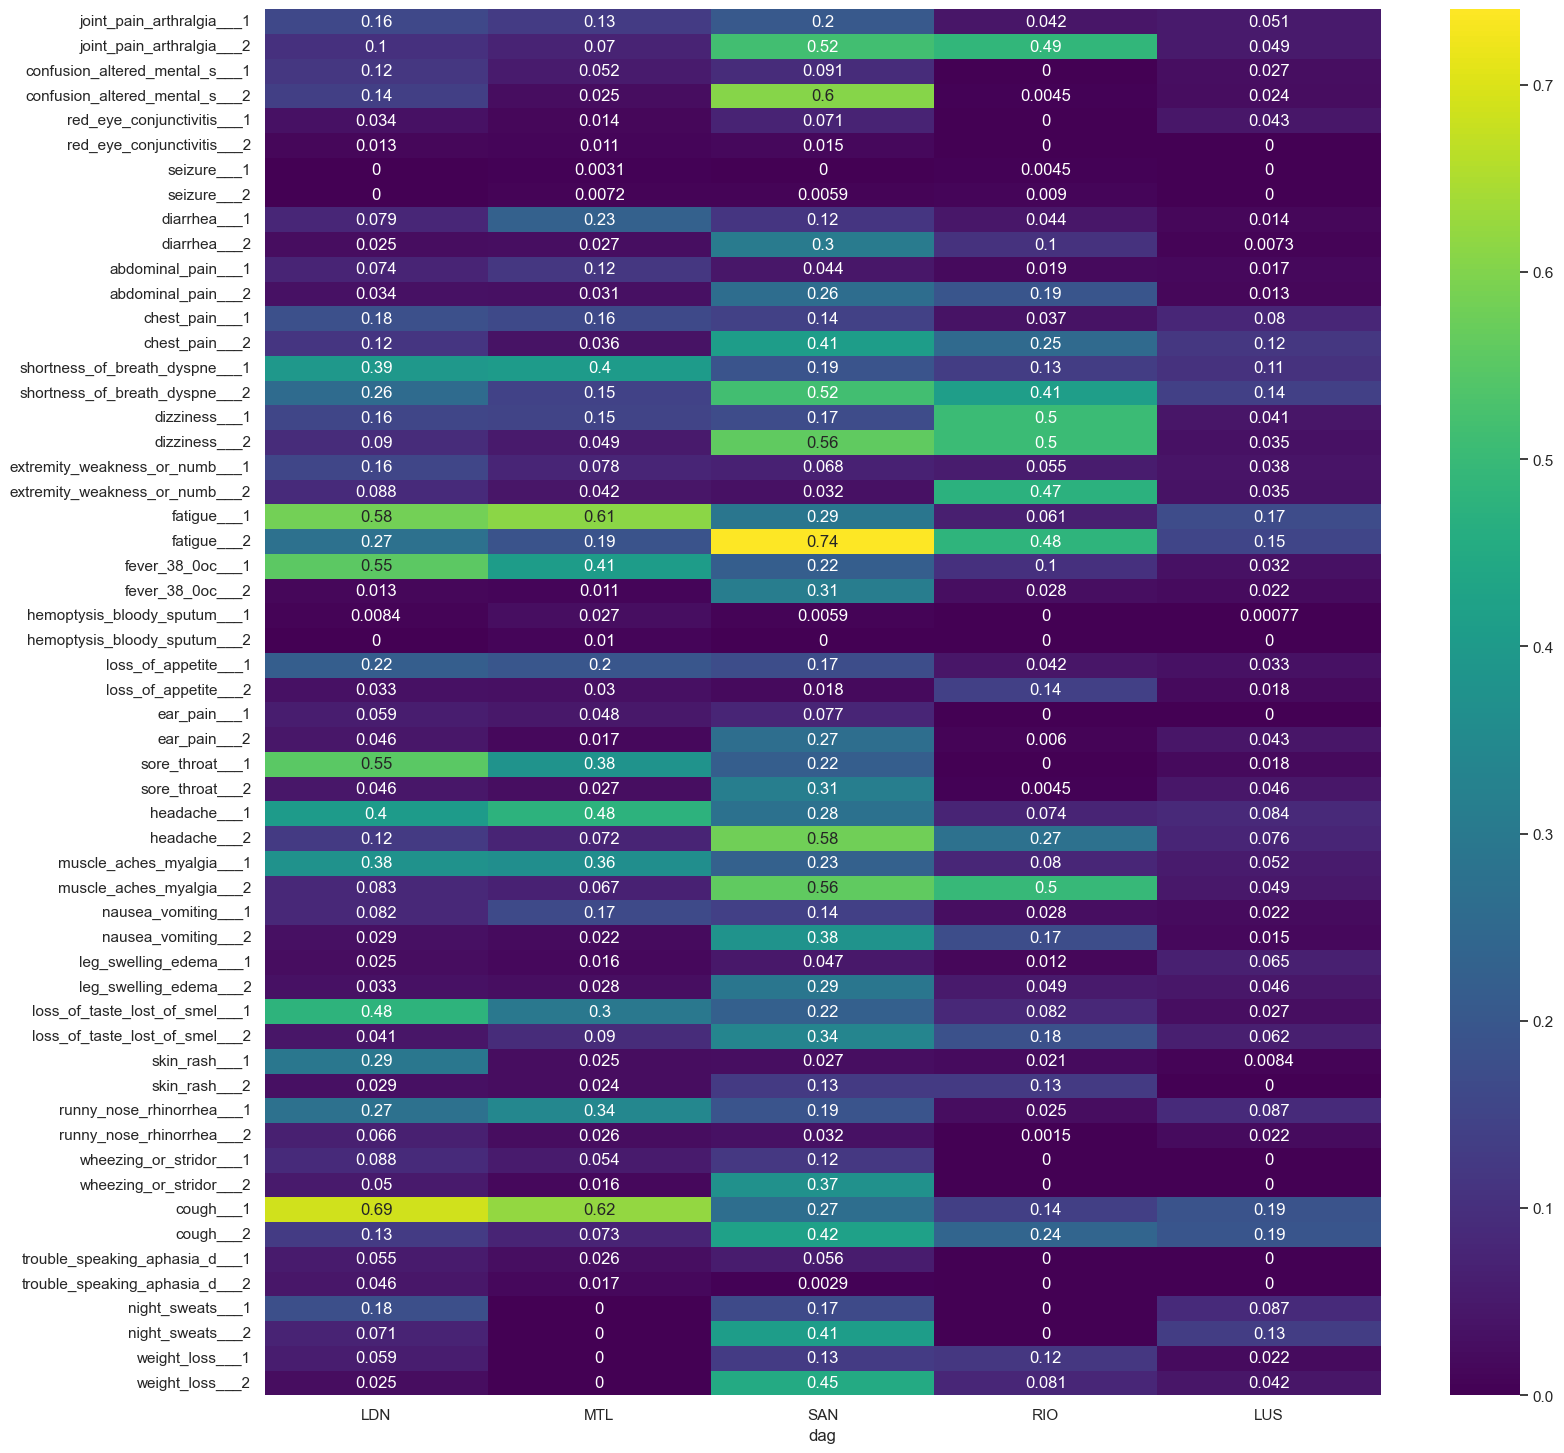

In [280]:
# get mean symptom value by site
symptom_mean = df.groupby('dag')[SYMP].sum().rename(index = site_name_dict).T / df.groupby('dag')[SYMP].count().rename(index = site_name_dict).T

fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(symptom_mean, cmap = 'viridis', annot = True, ax = ax)

In [281]:
# group the features by site
sc = df.groupby(df['dag'])['vaccinated']
sc

In [282]:
sc.mean()

dag
1    0.962733
2    0.991992
3    0.966867
4    0.947970
5    0.833780
Name: vaccinated, dtype: float64

In [283]:
# compare each site using wilcoxon rank sum test
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu, chisquare, kruskal

In [284]:
stat,p = kruskal(*[sc.get_group(i).dropna() for i in range(1,6)])

In [285]:
stat, p

(284.05078292617765, 2.9824237048692634e-60)

In [286]:
# cross tabulate SYMPT by SITE
sympt_by_site = df.groupby('dag')[SYMP].sum()
sympt_by_site


,joint_pain_arthralgia___1,joint_pain_arthralgia___2,confusion_altered_mental_s___1,confusion_altered_mental_s___2,red_eye_conjunctivitis___1,red_eye_conjunctivitis___2,seizure___1,seizure___2,diarrhea___1,diarrhea___2,...,wheezing_or_stridor___1,wheezing_or_stridor___2,cough___1,cough___2,trouble_speaking_aphasia_d___1,trouble_speaking_aphasia_d___2,night_sweats___1,night_sweats___2,weight_loss___1,weight_loss___2
dag,,,,,,,,,,,,,,,,,,,,,
1,38.0,25.0,29.0,35.0,8.0,3.0,0.0,0.0,19.0,6.0,...,21.0,12.0,211.0,33.0,13.0,11.0,42.0,17.0,14.0,6.0
2,374.0,204.0,152.0,74.0,40.0,32.0,9.0,21.0,664.0,78.0,...,156.0,48.0,1809.0,213.0,77.0,49.0,0.0,0.0,0.0,0.0
3,69.0,175.0,31.0,205.0,24.0,5.0,0.0,2.0,39.0,103.0,...,41.0,126.0,90.0,143.0,19.0,1.0,56.0,139.0,44.0,152.0
4,28.0,325.0,0.0,3.0,0.0,0.0,3.0,6.0,35.0,70.0,...,0.0,0.0,109.0,160.0,0.0,0.0,0.0,0.0,78.0,54.0
5,67.0,27.0,35.0,13.0,2.0,0.0,0.0,0.0,18.0,4.0,...,0.0,0.0,248.0,109.0,0.0,0.0,4.0,7.0,1.0,2.0


In [287]:
from scipy.stats import chi2_contingency

for col in SYMP:

# col = "chest_pain___2"

    ct = pd.crosstab(df['dag'], df[col]).rename(index = site_name_dict)

    result = chi2_contingency(ct)
    if result[1] < 0.05:
        # print(ct)
        print(f"{col}: p = {result[1]}")


joint_pain_arthralgia___1: p = 1.6100497954156042e-26
joint_pain_arthralgia___2: p = 2.9818656159205832e-232
confusion_altered_mental_s___1: p = 5.523096881553656e-19
confusion_altered_mental_s___2: p = 0.0
red_eye_conjunctivitis___1: p = 1.7740380744591983e-15
diarrhea___1: p = 3.7988378952271595e-92
diarrhea___2: p = 8.526881669836011e-108
abdominal_pain___1: p = 1.2320277326708788e-38
abdominal_pain___2: p = 8.544783171794661e-98
chest_pain___1: p = 1.9763050372339502e-26
chest_pain___2: p = 1.5253969364462908e-133
shortness_of_breath_dyspne___1: p = 2.59147187412474e-112
shortness_of_breath_dyspne___2: p = 7.007915382923837e-93
dizziness___1: p = 1.0642759917384678e-148
dizziness___2: p = 7.426043937171077e-300
extremity_weakness_or_numb___1: p = 1.0987598279774878e-10
extremity_weakness_or_numb___2: p = 1.8140341238774416e-246
fatigue___1: p = 2.4193193706410696e-254
fatigue___2: p = 3.0593640972409678e-143
fever_38_0oc___1: p = 1.5354605194986375e-188
fever_38_0oc___2: p = 1.6129

In [288]:
ftr = symptom_features.dropna()
tgt = df.loc[ftr.index]['dag']

ftr.shape, tgt.shape

((5663, 56), (5663,))

In [289]:
tgt.value_counts()

dag
2    2913
5    1304
4     788
3     339
1     319
Name: count, dtype: int64

In [290]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(multi_class = "multinomial")

# fit the model
logreg.fit(ftr, tgt)

# get the coefficients
coefs = logreg.coef_



In [291]:
pp = logreg.predict_proba(ftr)

In [292]:
qq = pd.concat([ftr, tgt], axis = 1)
qq

,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,SYMPT-cough___2,SYMPT-diarrhea___1,SYMPT-diarrhea___2,...,SYMPT-skin_rash___2,SYMPT-sore_throat___1,SYMPT-sore_throat___2,SYMPT-trouble_speaking_aphasia_d___1,SYMPT-trouble_speaking_aphasia_d___2,SYMPT-weight_loss___1,SYMPT-weight_loss___2,SYMPT-wheezing_or_stridor___1,SYMPT-wheezing_or_stridor___2,dag
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3
5659,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
5660,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


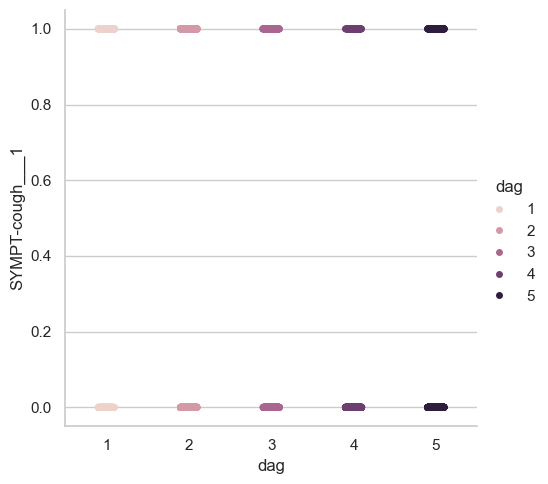

In [293]:
sns.catplot(data = qq, x = 'dag', y = 'SYMPT-cough___1', hue = 'dag', kind = 'strip')

<Axes: >

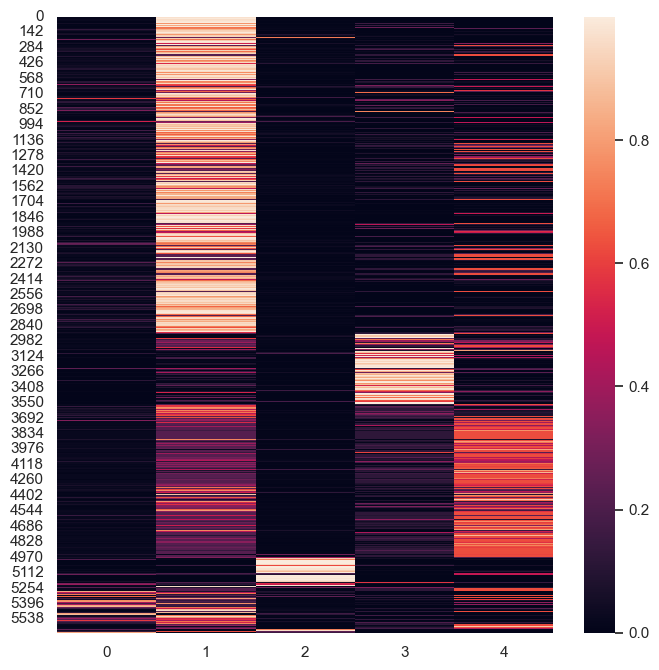

In [294]:
sns.heatmap(pp)

<Axes: >

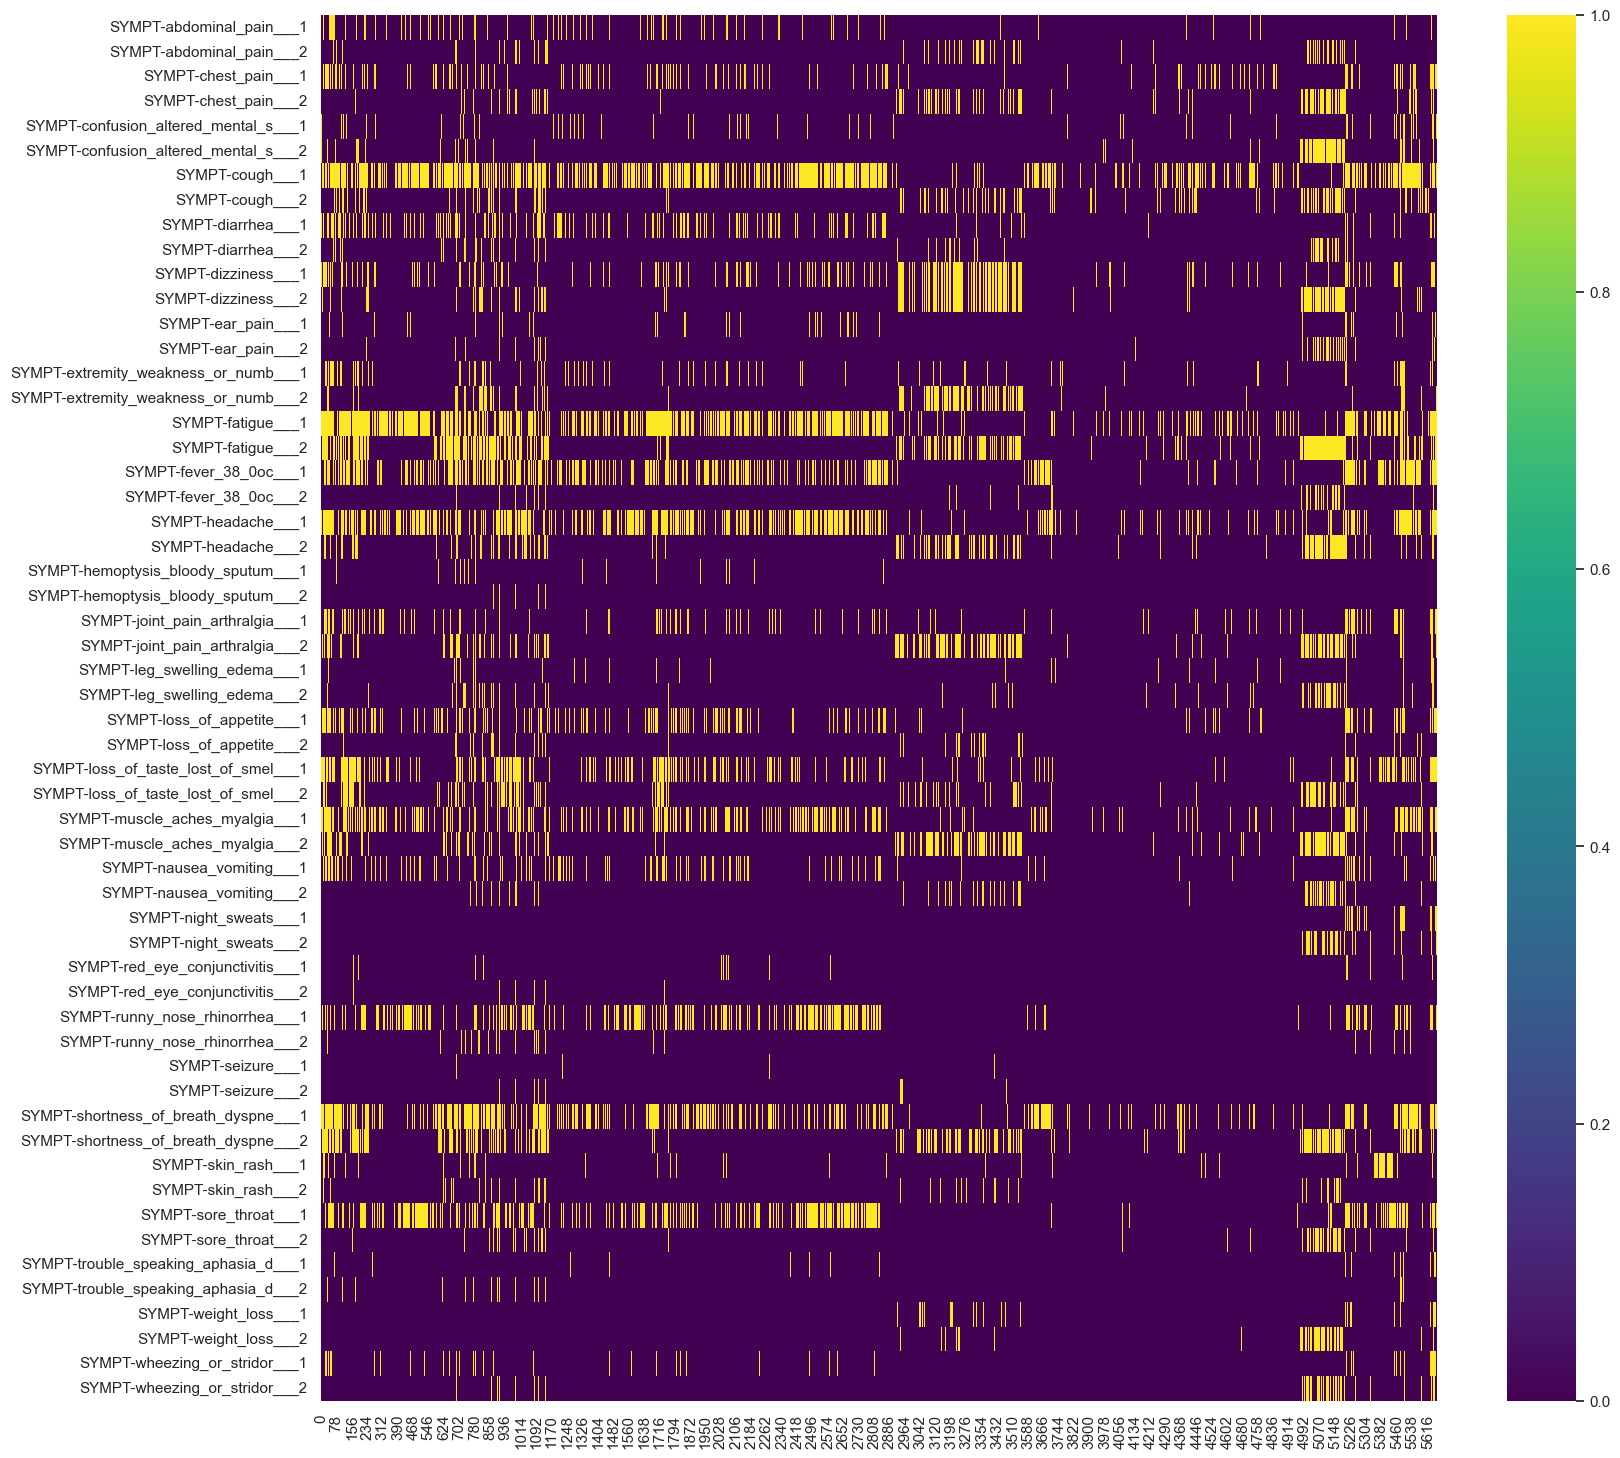

In [295]:
fig, ax = plt.subplots(figsize=(18,18))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [296]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

### IMG - Imaging

- assume that imaging (ct*, cx*, echo*, ekg*) were only ordered for patients that had symptoms or otherwised needed imaging
- for each modality, if the patient has a 1, the imaging was indicated, otherwise it was not indicated and encode a zero


In [297]:
#==============================================================================
# 2024-04-28: this is now DEPRECATED
#==============================================================================

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]

# # count items that start with ct
# print(df.filter(regex='^ct', axis = 1).count())
# df["ctaresult"].value_counts(), df["cttresult"].value_counts(), df["cthresult"].value_counts()
# CTA, CTT, CTH - most of the results are 2 - no report
# CONCLUSION: recommend dropping these - there are very few discriminant results
# # count items that start with cx
# print(df.filter(regex='^cx', axis = 1).count())
# # count cxr code values
# df["cxrresult"].value_counts(), df["cxrcode"].value_counts()

# # most are no-result. Of the 39 that are a positive finding, what are the results?


# # 33 fluid, etc
# # 3 fibrosis
# # 2 nodules, cysts
# # 2 congestive heart disease etc
# CONCLUSION: recommend dropping these too - very small numbers
# # # now echo
# # # count items that start with ct
# # print(df.filter(regex='^echo', axis = 1).count())

# # df["echoresult"].value_counts()
# # # mostly no reports, 7 positive findings
# # finally, ekg
# print(df.filter(regex='^ekg', axis = 1).count())

# print(df["ekgresult"].value_counts())

# print(df["ekgcode"].value_counts())

# # ekgcode results indicate 
# # 10 sinus bradycardia
# # 2 atrioventricular block
# # 1 each of supraventricular, sinus tachy, infarction

# # CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# # numbers are very very small
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [298]:

#==============================================================================
# 2024-04-28: issue #4 - assume imaging ordered for patients who need it for 
# some reason or another
#==============================================================================
# concept: either imaging is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that imaging was not indicated

IMAGING_INVESTIGATIONS = ["cta", "cth", "ctt", "cxr", "echocardiogram", "ekg", "imaging", "angiography",'pocus']

# pretty sure spirometry isn't an imaging modality, but it was either ordered for a px, or not
print(df[IMAGING_INVESTIGATIONS].info())

# if it wasn't reported, it we assume it wasn't ordered
# fill missing values with zero
imaging_features = df[IMAGING_INVESTIGATIONS].fillna(0)

# rename the columns by prepending IMG
imaging_features.columns = [f"IMG-{col}" for col in imaging_features.columns]

# summarize
imaging_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cta             71 non-null     float64
 1   cth             72 non-null     float64
 2   ctt             291 non-null    float64
 3   cxr             326 non-null    float64
 4   echocardiogram  235 non-null    float64
 5   ekg             251 non-null    float64
 6   imaging         50 non-null     float64
 7   angiography     45 non-null     float64
 8   pocus           45 non-null     float64
dtypes: float64(9)
memory usage: 398.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMG-cta             5663 non-null   float64
 1   IMG-cth             5663 non-null   float64
 2   IMG-ctt             5663 non-null   float64
 

### LAB - Lab Tests

#### Functional tests

In [299]:
# first, functional tests:
FUNC_TESTS = ["spirometry", "lung_function","metacholine"]

func_test_features = df[FUNC_TESTS]

# assume that functional tests were ordered for a reason
# fill missing values with 0
func_test_features = func_test_features.fillna(0)

# rename the columns by prepending LAB-test-
func_test_features.columns = [f"LAB-test-{col}" for col in func_test_features.columns]

func_test_features.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LAB-test-spirometry     5663 non-null   float64
 1   LAB-test-lung_function  5663 non-null   float64
 2   LAB-test-metacholine    5663 non-null   float64
dtypes: float64(3)
memory usage: 132.9 KB


#### Lab tests

In [300]:
# now, lab tests that aren't imaging or functional
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "metacholine", "lung_function","troponin"))]


# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp", "spirometry", "metacholine", "lung_function", "il6", "angiography"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1374 non-null   float64
 1   alt               1722 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1061 non-null   float64
 4   basophil          593 non-null    float64
 5   basophil_count    835 non-null    float64
 6   bilirubin         1452 non-null   float64
 7   bilirubin_direct  696 non-null    float64
 8   bnp               18 non-null     float64
 9   cd4               2 non-null      float64
 10  cd8               2 non-null      float64
 11  cpk               151 non-null    float64
 12  creatinine        1482 non-null   float64
 13  crp               1590 non-null   float64
 14  eosinophil        547 non-null    float64
 15  eosinophil_count  836 non-null    float64
 16  ferritin          898 non-null    float64


In [301]:
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
# plt.title("LAB Tests")

##### Treat Outliers

In [302]:
# treat outliers before imputing data
# if we even impute the data

from project_modules.data_prep import treat_outliers
labs_without_outliers = treat_outliers(df[CLINICAL_TESTS], z_threshold = 4, method = "median")

>>> Using z-threshold = 4.00 to identify outliers.
>>> There are 211 outliers in the data for abs(z) ≥ 4.00.
>>> Outliers are 3.73% of the total data.
>>> Replacing outliers with median.
albumin              40.000
alt                  27.000
aptt                 31.550
ast                  23.000
basophil              0.000
basophil_count        0.000
bilirubin             5.000
bilirubin_direct      0.100
bnp                  30.000
cd4                   0.470
cd8                   0.365
cpk                 107.000
creatinine           78.000
crp                   6.950
eosinophil            0.100
eosinophil_count      1.000
ferritin            156.000
fibrinogen            3.400
glucose               6.100
haemoglobin         134.000
igg                   9.000
il6                  35.100
inr                   1.100
ldh                 298.000
lymphocyte            1.200
lymphocyte_count     24.000
monocyte              0.600
monocyte_count        6.000
neutrophil            6.500
n

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [303]:
labs_without_outliers.describe()

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,bnp,cd4,...,ntprobnp,pct,platelets,pocus,potassium,sodium,stented,triglycerides,urea,wbc
count,1374.000000,1722.000000,580.000000,1061.000000,593.000000,835.000000,1452.000000,696.000000,18.000000,2.000000,...,82.000000,363.000000,2032.000000,45.0,1050.000000,1051.000000,45.0,856.000000,1271.000000,2046.000000
mean,39.166958,34.934925,31.978948,29.677286,0.139123,0.100240,11.338926,0.914943,98.388889,0.470000,...,1291.695122,0.278595,250.518898,0.0,4.083905,137.672693,0.0,103.490187,4.291675,7.399174
std,4.651731,24.988796,7.653760,21.853172,0.203152,0.295611,17.944805,3.297386,124.001963,0.169706,...,2884.132082,0.501534,88.961987,0.0,0.535346,4.072838,0.0,99.022346,3.838646,3.056715
min,17.000000,5.000000,1.400000,1.600000,0.000000,0.000000,0.000000,0.000000,7.000000,0.350000,...,10.000000,0.020000,1.000000,0.0,2.200000,121.000000,0.0,0.100000,0.300000,1.000000
25%,37.000000,19.000000,27.275000,17.000000,0.000000,0.000000,0.500000,0.100000,21.000000,0.410000,...,80.750000,0.080000,190.000000,0.0,3.800000,136.000000,0.0,1.775000,1.610000,5.400000
50%,40.000000,27.000000,31.525000,23.000000,0.000000,0.000000,5.000000,0.100000,30.000000,0.470000,...,267.500000,0.130000,243.000000,0.0,4.100000,138.000000,0.0,92.250000,3.300000,6.900000
75%,42.000000,41.000000,35.200000,33.000000,0.200000,0.000000,12.000000,0.100000,112.500000,0.530000,...,819.500000,0.240000,302.000000,0.0,4.400000,140.000000,0.0,149.000000,5.650000,8.800000
max,51.000000,179.400000,79.900000,161.000000,0.900000,1.000000,114.920000,23.200000,432.000000,0.590000,...,15369.000000,3.800000,634.000000,0.0,6.500000,153.000000,0.0,568.000000,22.800000,22.500000


##### Consider Imputation by Site 
Summary -- Too many missing per site -- avoid imputation - MP Apr 28

In [304]:
print('Percent Missing of Lab By Site')
(df.groupby("dag")[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(
    index=site_name_dict
).T / df.dag.value_counts().rename(index=site_name_dict)).round(2)

Percent Missing of Lab By Site


dag,LDN,LUS,MTL,RIO,SAN
albumin,0.99,1.00,0.82,0.20,0.35
alt,0.77,0.94,0.79,0.06,0.35
aptt,1.00,1.00,0.84,0.87,1.00
ast,1.00,0.94,0.94,0.06,0.82
basophil,1.00,1.00,0.87,1.00,0.40
basophil_count,0.94,1.00,1.00,0.19,0.47
bilirubin,0.98,1.00,0.80,0.20,0.34
bilirubin_direct,1.00,1.00,0.98,0.20,0.95
bnp,1.00,1.00,1.00,1.00,0.97
cd4,1.00,1.00,1.00,1.00,1.00


Percent Missing of Lab By Site


Text(0.5, 1.0, 'Percent of Lab Missing By Site')

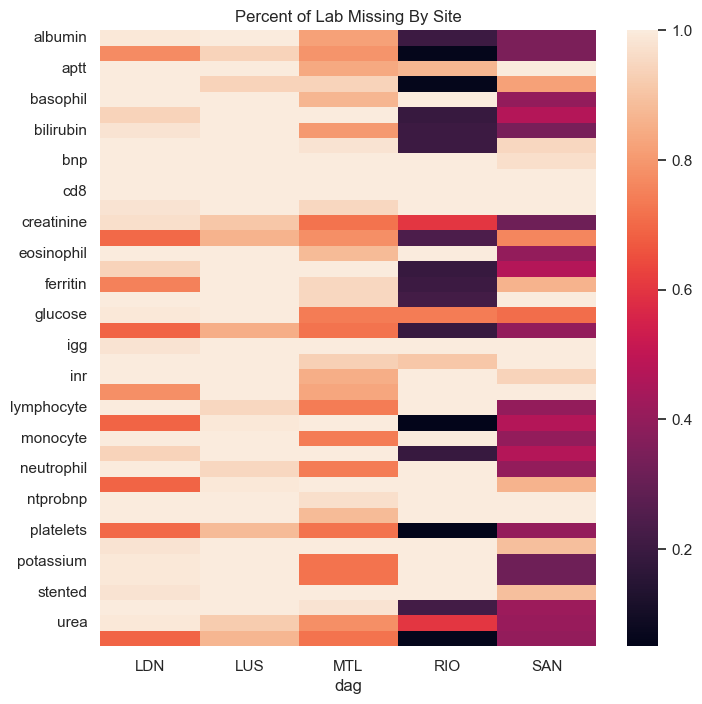

In [305]:
print('Percent Missing of Lab By Site')
sns.heatmap(
    (
        df.groupby("dag")[CLINICAL_TESTS]
        .apply(lambda x: x.isnull().sum())
        .rename(index=site_name_dict)
        .T
        / df.dag.value_counts().rename(index=site_name_dict)
    ).round(2)
)
plt.title("Percent of Lab Missing By Site")

In [306]:
#shows that there are no real good labs that have a decent number across all sites.. we just wouldnt beable to control for site differences between labs if imputed
print('Maximum percent missing per lab across all site.')
((df.groupby("dag")[CLINICAL_TESTS].apply(
    lambda x: x.isnull().sum()
).T / df.dag.value_counts()).round(2)).T.max().sort_values()

Maximum percent missing per lab across all site.


haemoglobin         0.85
crp                 0.86
wbc                 0.87
platelets           0.88
alt                 0.94
creatinine          0.97
urea                0.99
lymphocyte_count    1.00
monocyte            1.00
monocyte_count      1.00
neutrophil          1.00
neutrophil_count    1.00
ast                 1.00
ntprobnp            1.00
pct                 1.00
pocus               1.00
potassium           1.00
sodium              1.00
stented             1.00
triglycerides       1.00
lymphocyte          1.00
ldh                 1.00
il6                 1.00
aptt                1.00
basophil            1.00
basophil_count      1.00
bilirubin           1.00
bilirubin_direct    1.00
bnp                 1.00
cd4                 1.00
inr                 1.00
cd8                 1.00
eosinophil          1.00
eosinophil_count    1.00
ferritin            1.00
fibrinogen          1.00
glucose             1.00
igg                 1.00
cpk                 1.00
albumin             1.00


In [307]:
# how many nulls per site?
print("Missing LAB values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing LAB values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",117,158,"1,304"
alt,246,"2,303",118,48,"1,226"
aptt,318,"2,436",339,686,"1,304"
ast,319,"2,728",279,48,"1,228"
basophil,319,"2,523",136,788,"1,304"
basophil_count,300,"2,913",161,150,"1,304"
bilirubin,313,"2,323",116,155,"1,304"
bilirubin_direct,319,"2,867",323,154,"1,304"
bnp,319,"2,906",328,788,"1,304"
cd4,319,"2,911",339,788,"1,304"


##### consider imputing the labs data, by sex and by site

In [308]:
# # given the labs_without_outliers, we need to add sex and site back in
# # we also need to add in the LC_STATUS column

# t1 = pd.concat([labs_without_outliers, df[["sex", "dag"]]
#                 ], axis = 1)

# norm = mc.LogNorm(vmin=1, vmax=1_000)

# # get means by site
# sns.heatmap(t1.groupby("dag").median().T, norm = norm)
# plt.title("Median Values of LAB Tests by Site")


In [309]:
# 2024-04-28: this is now DEPRECATED
# originally the haemoglobin values were measured in different unit systems

# # let's have a look
# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = "dag", y = "haemoglobin", ax = ax)

# # simple unit check
# # hameoglobin is specified in diction as [g L^-1]
# # normal range is 130-180 [g L^-1]
# # LUSAKA values are in the 10s, so must be in [g dL^-1]
# # convert to [g L^-1]

# # find the LUSAKA values
# lusaka_haemoglobin = t1.query('dag == 5')["haemoglobin"]

# # convert to [g L^-1]
# lusaka_haemoglobin = lusaka_haemoglobin * 10

# lusaka_haemoglobin.describe()

# # now we can see that the values are in the normal range

# # replace the values in the dataframe
# t1.loc[t1["dag"] == 5, "haemoglobin"] = lusaka_haemoglobin

# # haemoglobin values look odd in a table DT made
# # let's have a look

# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = t1["dag"].map(site_name_dict), y = "haemoglobin", ax = ax)

In [310]:
# median_by_site_and_sex = t1.groupby(["sex", "dag"]).median().T
# median_by_site_and_sex

In [311]:
                                 
# # group by sex and dag
# t2 = t1.groupby(["sex", "dag"]).transform(lambda x: x.fillna(x.median()))

# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [312]:
# # are there records that are entirely nan?
# t2[t2.isna().all(axis = 1)]
# t2.dropna(how = 'all', inplace = True)
# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [313]:
# # drop some additional labs that have poor coverage

# CT2 = [col for col in CLINICAL_TESTS if not col.startswith(("eos", "meta", "m,ono", "neutro","potas","sodiu", "tri", "baso", "mono", "lymph"))]

# t3 = t2[CT2]

# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))

# norm = mc.LogNorm(vmin=1, vmax=10_000)

# sns.heatmap(t3.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [314]:
# # which features have a complete set of data (no missing values)?

# complete_features = t3.dropna(axis = 1, how = 'any') # type: ignore
# complete_features

##### Check distribution of complete_features by sex and dag

In [315]:
# pd.crosstab(t1.dag,t1.sex)

In [316]:
# t1.groupby(["dag", "sex"]).count()[
#     [
#         "LABS-alt",
#         "LABS-creatinine",
#         "LABS-crp",
#         "LABS-haemoglobin",
#         "LABS-platelets",
#         "LABS-urea",
#         "LABS-wbc",
#     ]
# ]

##### Generate lab_features

In [317]:
# lab_features 

In [318]:
# WIP: DO NOT IMPUTE

# no imputation
lab_features = labs_without_outliers
lab_features_ind = deepcopy(lab_features)

# no imputation, fixed LUS haemo values ## 2024-04-28: this is now DEPRECATED
# lab_features = t1.drop(["sex", "dag"], axis = 1)


# EXPT: use the reduced set of labs
# lab_features = complete_features

# rename the colummns by prefixing with LABS
lab_features.columns = [f"LABS-{col}" for col in lab_features.columns]

lab_features.shape

(5663, 40)

In [319]:
# h0w many null values per site?
print("Missing LAB values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore

Missing LAB values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",117,158,"1,304"
alt,246,"2,303",118,48,"1,226"
aptt,318,"2,436",339,686,"1,304"
ast,319,"2,728",279,48,"1,228"
basophil,319,"2,523",136,788,"1,304"
basophil_count,300,"2,913",161,150,"1,304"
bilirubin,313,"2,323",116,155,"1,304"
bilirubin_direct,319,"2,867",323,154,"1,304"
bnp,319,"2,906",328,788,"1,304"
cd4,319,"2,911",339,788,"1,304"


In [320]:
# ==============================================================================
# 2024-04-28: issue #3 - assume lab ordered for patients who need it for
# some reason or another
# ==============================================================================
# concept: either lab is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that lab was not indicated

# lab_features_ind = deepcopy(lab_features)
lab_features_ind = lab_features_ind.fillna(0)
lab_features_ind[lab_features_ind>0] = 1
lab_features_ind.columns = [f"LABS-IND-{col}" for col in lab_features_ind.columns]

In [321]:
lab_features.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LABS-albumin           1374 non-null   float64
 1   LABS-alt               1722 non-null   float64
 2   LABS-aptt              580 non-null    float64
 3   LABS-ast               1061 non-null   float64
 4   LABS-basophil          593 non-null    float64
 5   LABS-basophil_count    835 non-null    float64
 6   LABS-bilirubin         1452 non-null   float64
 7   LABS-bilirubin_direct  696 non-null    float64
 8   LABS-bnp               18 non-null     float64
 9   LABS-cd4               2 non-null      float64
 10  LABS-cd8               2 non-null      float64
 11  LABS-cpk               151 non-null    float64
 12  LABS-creatinine        1482 non-null   float64
 13  LABS-crp               1590 non-null   float64
 14  LABS-eosinophil        547 non-null    float64
 15  LABS

In [322]:
lab_features_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LABS-IND-albumin           5663 non-null   float64
 1   LABS-IND-alt               5663 non-null   float64
 2   LABS-IND-aptt              5663 non-null   float64
 3   LABS-IND-ast               5663 non-null   float64
 4   LABS-IND-basophil          5663 non-null   float64
 5   LABS-IND-basophil_count    5663 non-null   float64
 6   LABS-IND-bilirubin         5663 non-null   float64
 7   LABS-IND-bilirubin_direct  5663 non-null   float64
 8   LABS-IND-bnp               5663 non-null   float64
 9   LABS-IND-cd4               5663 non-null   float64
 10  LABS-IND-cd8               5663 non-null   float64
 11  LABS-IND-cpk               5663 non-null   float64
 12  LABS-IND-creatinine        5663 non-null   float64
 13  LABS-IND-crp               5663 non-null   float

## CLINICAL DETAILS

In [323]:
# 2024-04-28
# reconsidering this in light of some email discussions.
# - let's leave it as CD-* for all of the clinical details columns
# - we should rename any of the ones that start are generic
# "complications" ones with COMP

In [324]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-clin-details.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
CD = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
CD = [col for col in CD if not col.startswith(("phx", "phq"))]

# feature set for symptoms
cd_features = df[CD]

# preprend CLIN- to the column names
cd_features.columns = [f"CD-{col}" for col in cd_features.columns]

# find spaces in the data and replace with zero
cd_features = cd_features.replace(" ", 0)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_67142/2295893641.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd_features = cd_features.replace(" ", 0)


In [325]:
# find items in CD that include "complic"
# these are the complications columns
complications = [col for col in cd_features.columns if "complic" in col if "of_the_endoc" not in col]
complications

['CD-cardiovascular_complicatio___1',
 'CD-cardiovascular_complicatio___2',
 'CD-cardiovascular_complicatio___3',
 'CD-cardiovascular_complicatio___4',
 'CD-respiratory_complications___1',
 'CD-respiratory_complications___2',
 'CD-respiratory_complications___3',
 'CD-respiratory_complications___4',
 'CD-renal_complications___1',
 'CD-renal_complications___2',
 'CD-renal_complications___3',
 'CD-renal_complications___4',
 'CD-neurologic_complications___1',
 'CD-neurologic_complications___2',
 'CD-neurologic_complications___3',
 'CD-neurologic_complications___4',
 'CD-psychiatric_complications___1',
 'CD-psychiatric_complications___2',
 'CD-psychiatric_complications___3',
 'CD-psychiatric_complications___4',
 'CD-gastrointestinal_complicat___1',
 'CD-gastrointestinal_complicat___2',
 'CD-gastrointestinal_complicat___3',
 'CD-gastrointestinal_complicat___4']

In [326]:
# for each item in complications, split at the first underscore and rename the column
for col in complications:
    new_name =  col.split("_", 1)[0] + "-other-" + col.split("___", 1)[1]
    print(new_name)
    cd_features = cd_features.rename(columns = {col: new_name})

CD-cardiovascular-other-1
CD-cardiovascular-other-2
CD-cardiovascular-other-3
CD-cardiovascular-other-4
CD-respiratory-other-1
CD-respiratory-other-2
CD-respiratory-other-3
CD-respiratory-other-4
CD-renal-other-1
CD-renal-other-2
CD-renal-other-3
CD-renal-other-4
CD-neurologic-other-1
CD-neurologic-other-2
CD-neurologic-other-3
CD-neurologic-other-4
CD-psychiatric-other-1
CD-psychiatric-other-2
CD-psychiatric-other-3
CD-psychiatric-other-4
CD-gastrointestinal-other-1
CD-gastrointestinal-other-2
CD-gastrointestinal-other-3
CD-gastrointestinal-other-4


In [327]:
# bring back the endocrine complications
# endocrine complications
endocrine_complications = [col for col in cd_features.columns if "of_the_endoc" in col]
endocrine_complications

# rename the endocrine complications
for col in endocrine_complications:
    new_name =  "CD-endocrine-other-" + col.split("___", 1)[1]
    print(new_name)
    cd_features = cd_features.rename(columns = {col: new_name})

CD-endocrine-other-1
CD-endocrine-other-2
CD-endocrine-other-3
CD-endocrine-other-4


In [328]:
# drop columns with dtype datetime64
cd_features = cd_features.select_dtypes(exclude = ['datetime64', 'object'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Columns: 310 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310)
memory usage: 13.4 MB


Text(0.5, 1.0, 'COMP - Complications Status- missing values are light coloured')

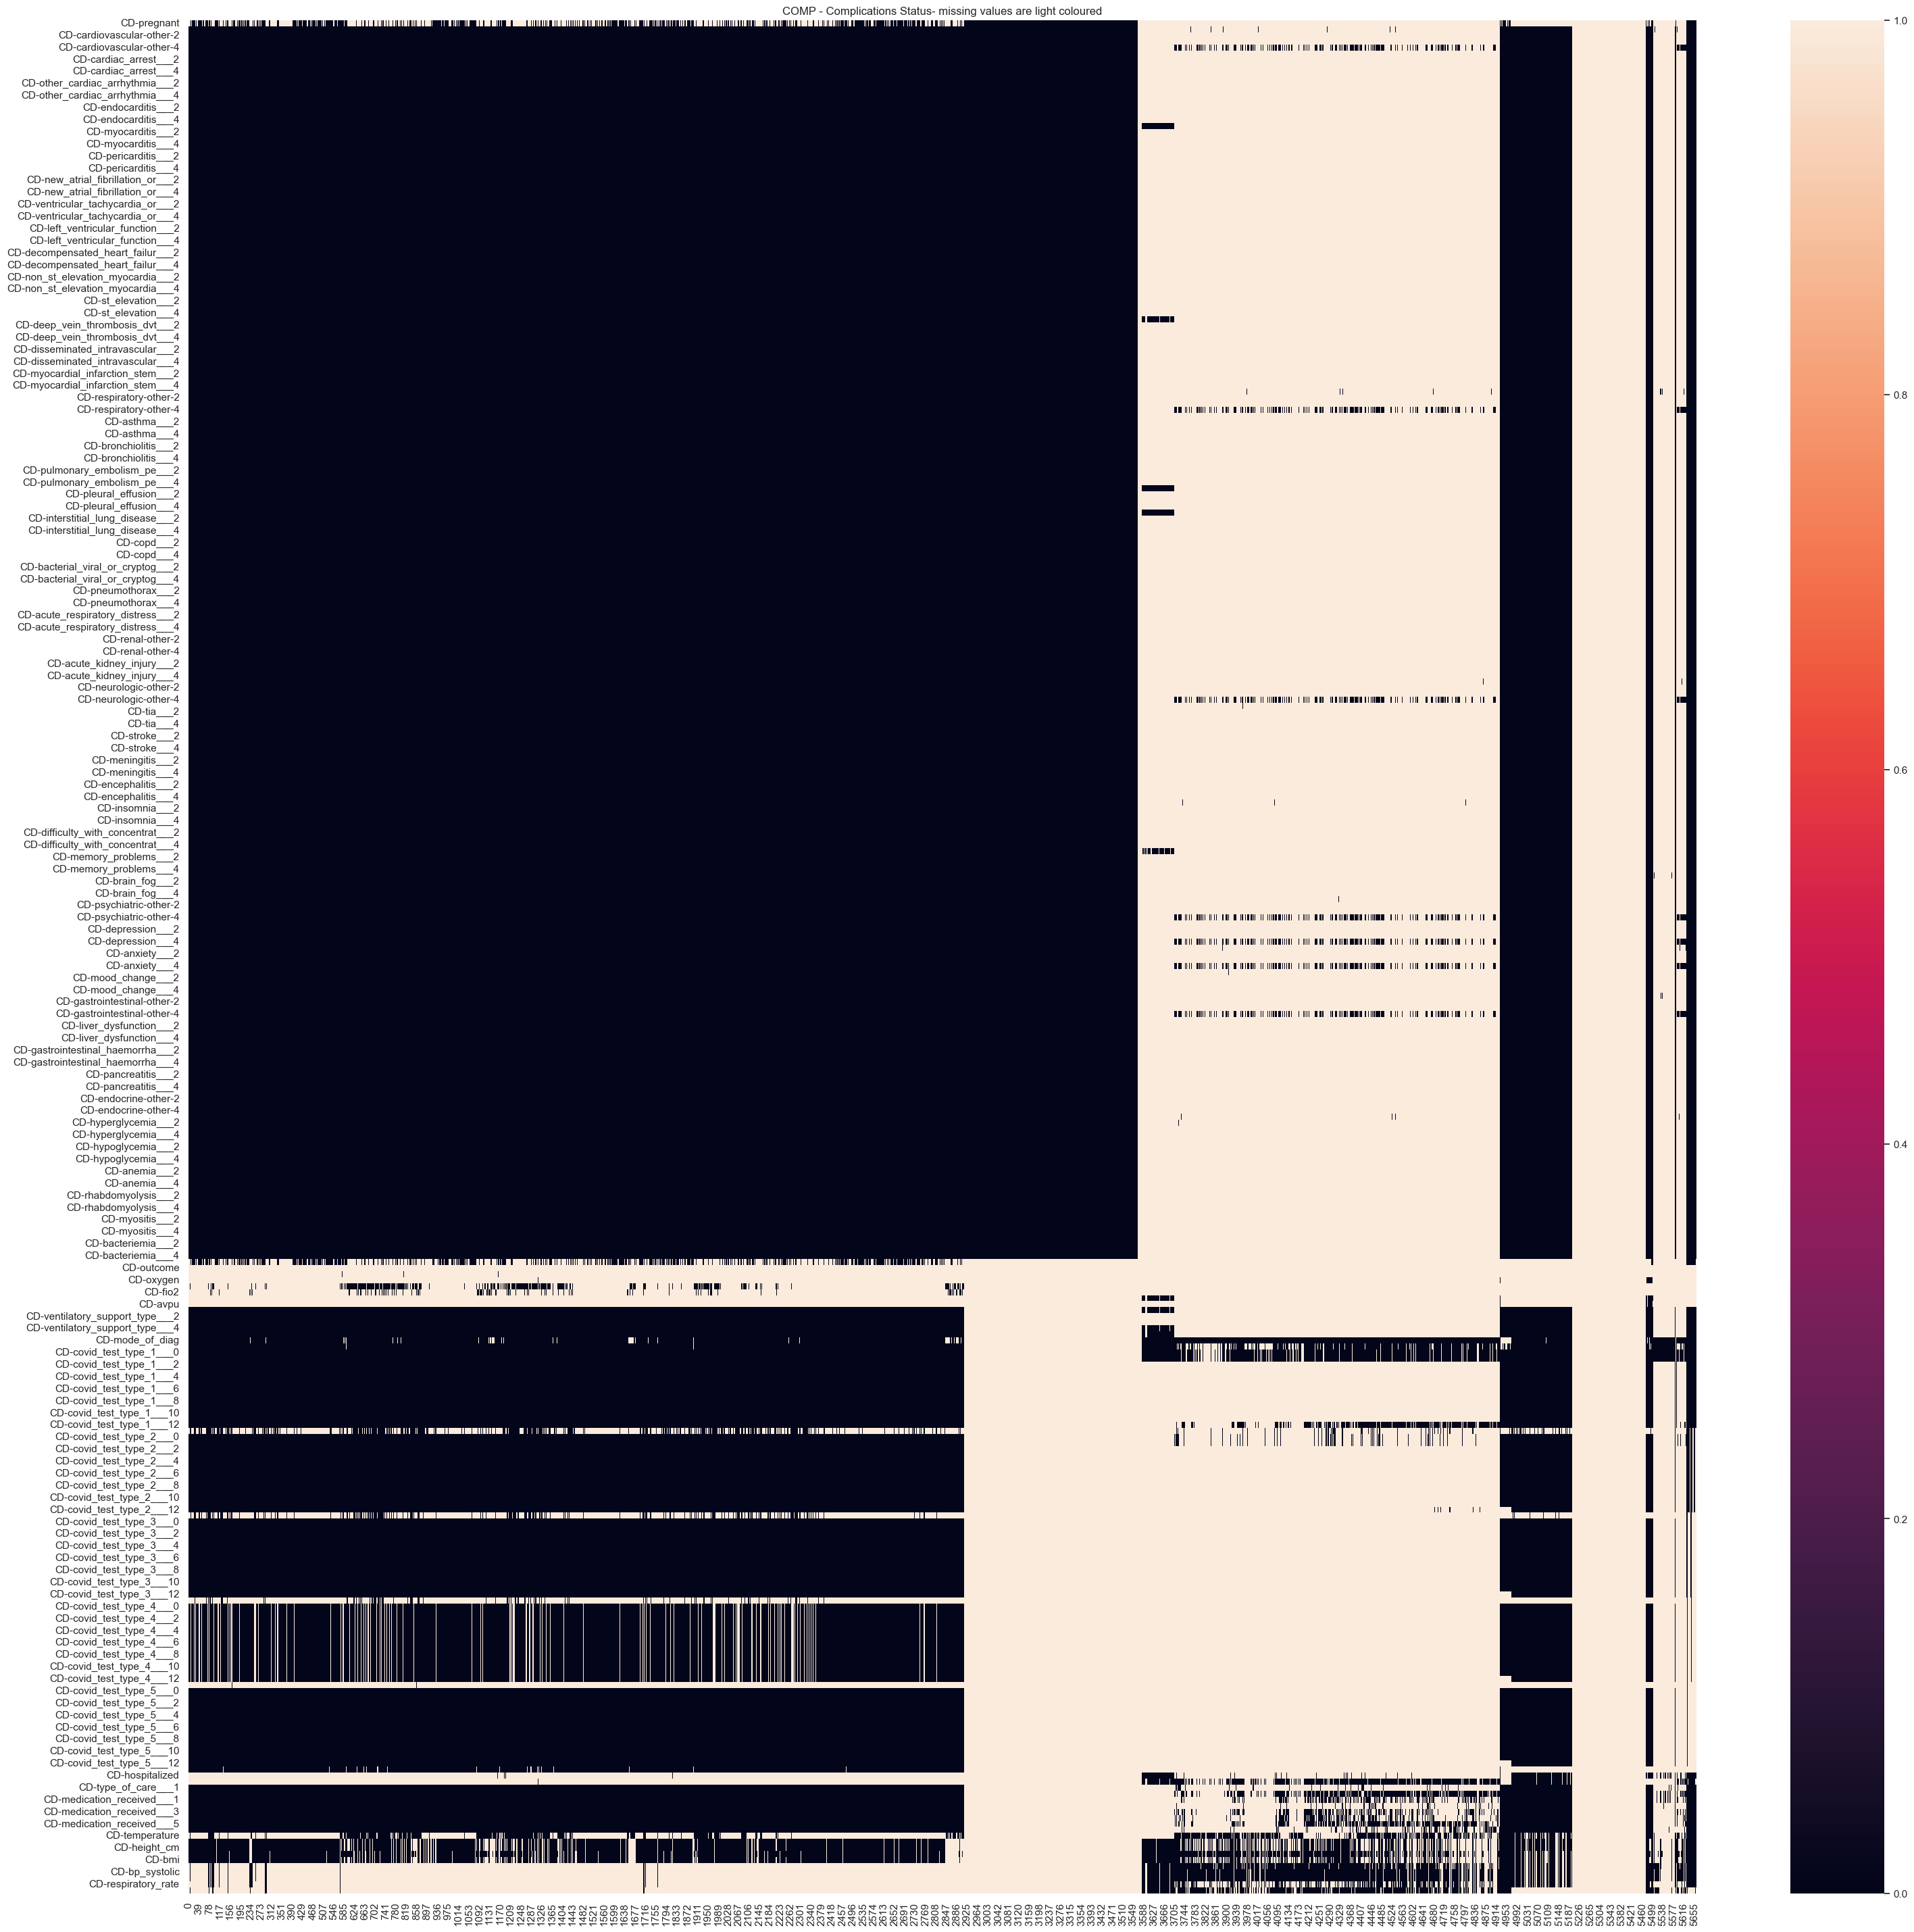

In [329]:

fig, ax = plt.subplots(figsize=(36,36))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("COMP - Complications Status- missing values are light coloured")

In [330]:
# # these features are not very informative - consider dropping them
cd_features = cd_features.drop(columns = cd_features.filter(like = "test_type").columns)

# # height in metres and centimetres is redundant
# # drop the height in cm
cd_features = cd_features.drop(columns = "CD-height_cm")


In [331]:
# sort alphabetically
cd_features = cd_features.reindex(sorted(cd_features.columns), axis=1)

In [332]:
# list of non-binary features - we shouldn't set these to zero!
nb_cd = ["temperature", "height_m", "height_cm", "weight_kgs", "bmi", "heart_rate", "bp_systolic", "bp_diastolic", "respiratory_rate", "o2_saturation", "spo2", "fio2", "gcs"]

nb_cd = [f"CD-{col}" for col in nb_cd]
nb_cd

['CD-temperature',
 'CD-height_m',
 'CD-height_cm',
 'CD-weight_kgs',
 'CD-bmi',
 'CD-heart_rate',
 'CD-bp_systolic',
 'CD-bp_diastolic',
 'CD-respiratory_rate',
 'CD-o2_saturation',
 'CD-spo2',
 'CD-fio2',
 'CD-gcs']

In [333]:
cd_features["CD-severity_level"].value_counts()

CD-severity_level
1.0    2014
2.0     455
3.0     214
0.0     177
Name: count, dtype: int64

In [334]:
#==============================================================================
# 2024-04-28
#==============================================================================
# fill the missing values with zero, per email discussion 2024-04-28

to_fill = [col for col in cd_features.columns if col not in nb_cd]

cd_features[to_fill] = cd_features[to_fill].fillna(0)


In [335]:
cd_features.shape

(5663, 244)

In [336]:
# one hot encode severity level because categories, from 0,1,2,3,4
cd_features['CD-severity_level'] = cd_features['CD-severity_level'].astype(int)

In [337]:
cd_features = pd.get_dummies(cd_features,columns=['CD-severity_level',], prefix='CD-severity_level__')

In [338]:
# convert booleans to ints

cdb = cd_features.select_dtypes(include = ['bool']).columns
cd_features[cdb] = cd_features[cdb].astype(int)
cd_features

,CD-acute_kidney_injury___1,CD-acute_kidney_injury___2,CD-acute_kidney_injury___3,CD-acute_kidney_injury___4,CD-acute_respiratory_distress___1,CD-acute_respiratory_distress___2,CD-acute_respiratory_distress___3,CD-acute_respiratory_distress___4,CD-adjunctive___1,CD-anemia___1,...,CD-ventilatory_support_type___4,CD-ventricular_tachycardia_or___1,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs,CD-severity_level___0,CD-severity_level___1,CD-severity_level___2,CD-severity_level___3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,79.00,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,55.00,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67.00,0,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,136.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,102.68,1,0,0,0
5659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,93.38,1,0,0,0
5660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,125.79,1,0,0,0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,71.24,1,0,0,0


In [339]:
# # clip cd_features to 0,1
# cd_features = cd_features.clip(0,1)
# cd_features.max().max()

In [340]:
print("Missing COMP values by site:")
ot1 = cd_features.groupby(df["dag"]).apply(lambda x: x.isnull().sum()).rename(
    index=site_name_dict
).T
ot1

Missing COMP values by site:


dag,LDN,MTL,SAN,RIO,LUS
CD-acute_kidney_injury___1,0,0,0,0,0
CD-acute_kidney_injury___2,0,0,0,0,0
CD-acute_kidney_injury___3,0,0,0,0,0
CD-acute_kidney_injury___4,0,0,0,0,0
CD-acute_respiratory_distress___1,0,0,0,0,0
...,...,...,...,...,...
CD-weight_kgs,267,385,154,668,345
CD-severity_level___0,0,0,0,0,0
CD-severity_level___1,0,0,0,0,0
CD-severity_level___2,0,0,0,0,0


Text(0.5, 1.0, 'CD Status - missing values are light coloured')

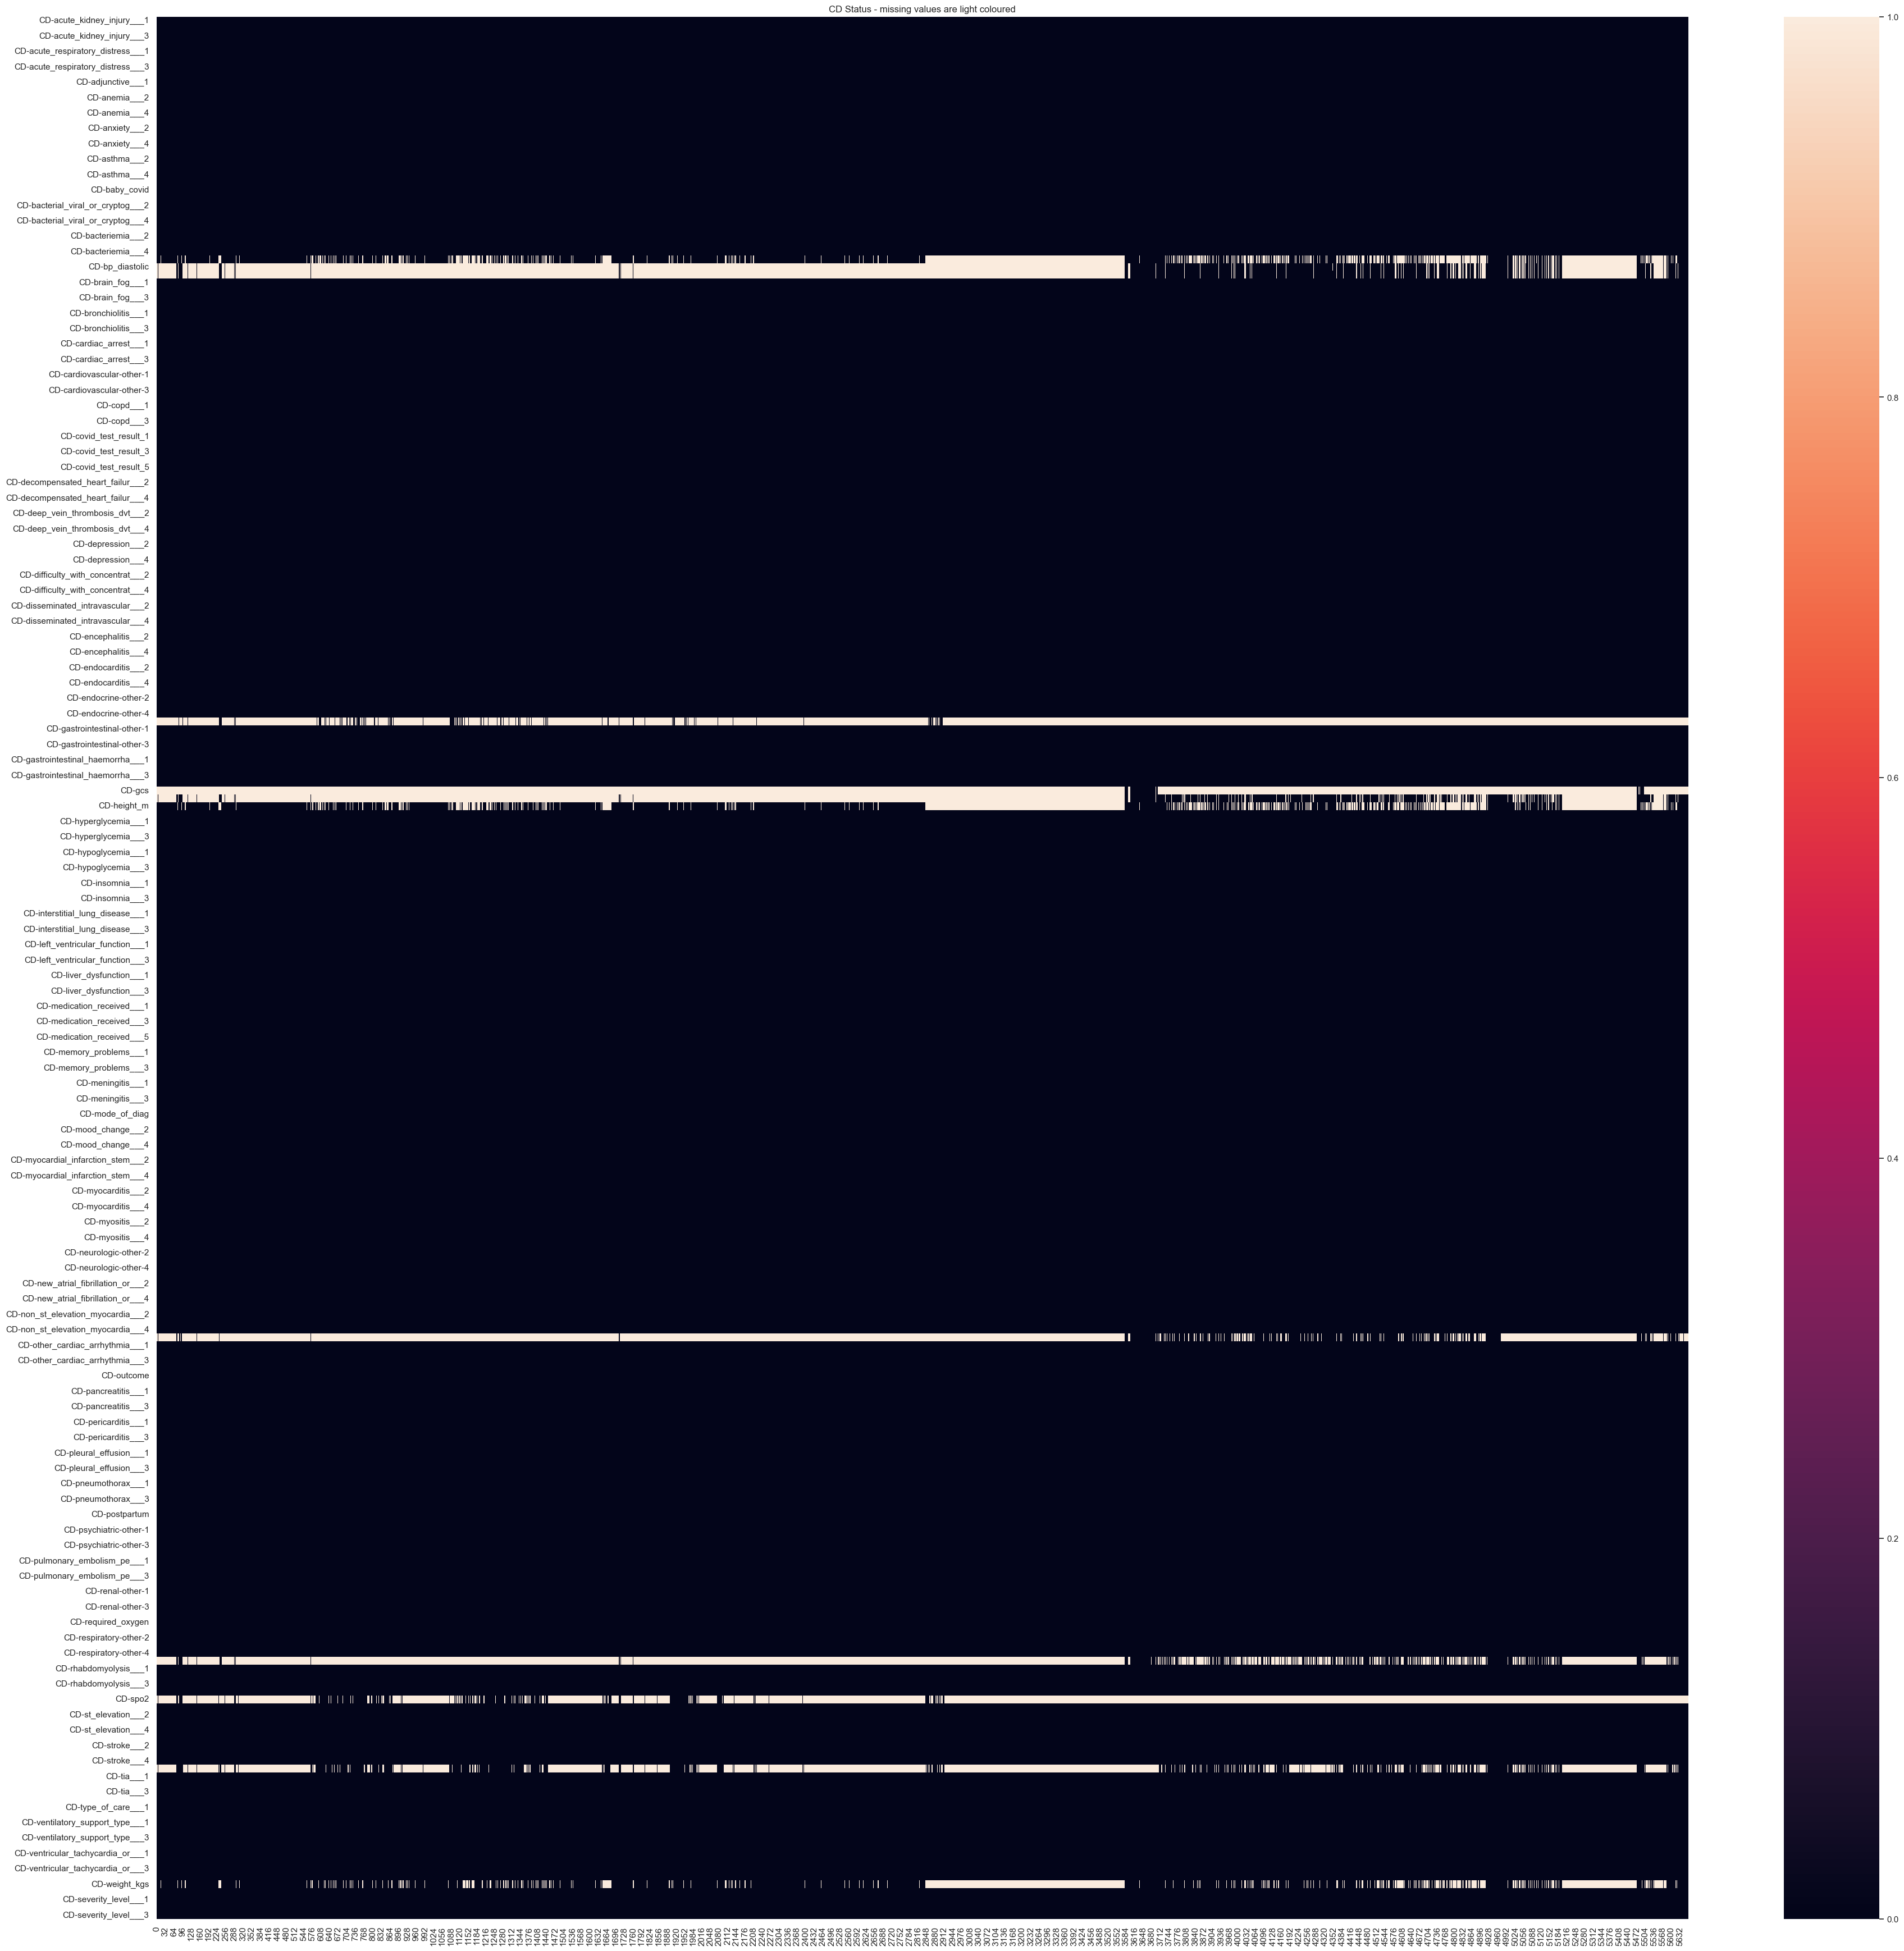

In [341]:

fig, ax = plt.subplots(figsize=(44,44))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CD Status - missing values are light coloured")
# missing values by site

##### Convert Vitals and Non-Binary CD to Indicated/NonIndicated

In [342]:
print('confirm data not mistakenly filled wtih 0 for non-binary')
ot1.loc[ot1.sum(axis=1) > 0]

confirm data not mistakenly filled wtih 0 for non-binary


dag,LDN,MTL,SAN,RIO,LUS
CD-bmi,277,480,156,668,642
CD-bp_diastolic,266,2853,149,680,151
CD-bp_systolic,266,2853,149,680,150
CD-fio2,319,2659,339,788,1304
CD-gcs,295,2913,339,681,1303
CD-heart_rate,263,2853,149,681,225
CD-height_m,277,424,116,668,615
CD-o2_saturation,270,2883,335,682,304
CD-respiratory_rate,293,2858,149,681,711
CD-spo2,319,2155,339,788,1304


In [343]:
nb_cd

['CD-temperature',
 'CD-height_m',
 'CD-height_cm',
 'CD-weight_kgs',
 'CD-bmi',
 'CD-heart_rate',
 'CD-bp_systolic',
 'CD-bp_diastolic',
 'CD-respiratory_rate',
 'CD-o2_saturation',
 'CD-spo2',
 'CD-fio2',
 'CD-gcs']

In [344]:
NBCD_IND = [
    "CD-temperature",
    "CD-heart_rate",
    "CD-bp_systolic",
    "CD-bp_diastolic",
    "CD-respiratory_rate",
    "CD-o2_saturation",
    "CD-spo2",
    "CD-fio2",
    "CD-gcs",
]

In [345]:
# ==============================================================================
# 2024-04-28
# ==============================================================================
# Binarize Vital Columns, per email discussion 2024-04-28
# separate vitals and other features

cd_NBCD = cd_features[NBCD_IND]
cd_NBCD = cd_NBCD.fillna(0)

cd_NBCD[cd_NBCD > 0] = 1

cd_features = cd_features[[x for x in cd_features.columns if x not in NBCD_IND+[ 'CD-height_m','CD-height_cm', 'CD-weight_kgs', 'CD-bmi',]]] #remove NB_CD columns and H/W from cd_features
# lab_features_ind.columns = [f"LABS-IND-{col}" for col in lab_features_ind.columns]
cd_NBCD.shape, cd_features.shape

((5663, 9), (5663, 235))

In [346]:
cd_NBCD['CD-spo2'].value_counts()

CD-spo2
0.0    4905
1.0     758
Name: count, dtype: int64

## PRECOVID FEATURES

In [347]:
# pre-lc statis

# read the list of symtpoms from the json file
import json
with open("./JSON/list-precov.json", "r") as f:
    precov_list = json.load(f)

PC = [col for col in df.columns if  col.startswith(tuple(precov_list))]

precov_features = df[PC]

In [348]:
# rename the columns by prefixing with PRECOV
precov_features.columns = [f"PRECOV-{col}" for col in precov_features.columns]

# fill missing values with zero
precov_features = precov_features.fillna(0)

precov_features

,PRECOV-ventilatory_support_type___1,PRECOV-ventilatory_support_type___2,PRECOV-ventilatory_support_type___3,PRECOV-ventilatory_support_type___4,PRECOV-adjunctive___1,PRECOV-mode_of_diag,PRECOV-covid_test_result_1,PRECOV-covid_test_result_2,PRECOV-covid_test_result_3,PRECOV-covid_test_result_4,...,PRECOV-hospitalized,PRECOV-required_oxygen,PRECOV-type_of_care___1,PRECOV-type_of_care___2,PRECOV-medication_received___1,PRECOV-medication_received___2,PRECOV-medication_received___3,PRECOV-medication_received___4,PRECOV-medication_received___5,PRECOV-medication_received___6
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5659,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5661,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [349]:
# how many nans?
print("Missing PRECOV values by site:")
df.groupby('dag')[PC].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

# how many nulls in procov, not by site
print("Missing PRECOV values:")
precov_features.isnull().sum()


Missing PRECOV values by site:
Missing PRECOV values:


PRECOV-ventilatory_support_type___1    0
PRECOV-ventilatory_support_type___2    0
PRECOV-ventilatory_support_type___3    0
PRECOV-ventilatory_support_type___4    0
PRECOV-adjunctive___1                  0
PRECOV-mode_of_diag                    0
PRECOV-covid_test_result_1             0
PRECOV-covid_test_result_2             0
PRECOV-covid_test_result_3             0
PRECOV-covid_test_result_4             0
PRECOV-covid_test_result_5             0
PRECOV-severity_level                  0
PRECOV-hospitalized                    0
PRECOV-required_oxygen                 0
PRECOV-type_of_care___1                0
PRECOV-type_of_care___2                0
PRECOV-medication_received___1         0
PRECOV-medication_received___2         0
PRECOV-medication_received___3         0
PRECOV-medication_received___4         0
PRECOV-medication_received___5         0
PRECOV-medication_received___6         0
dtype: int64

<Axes: >

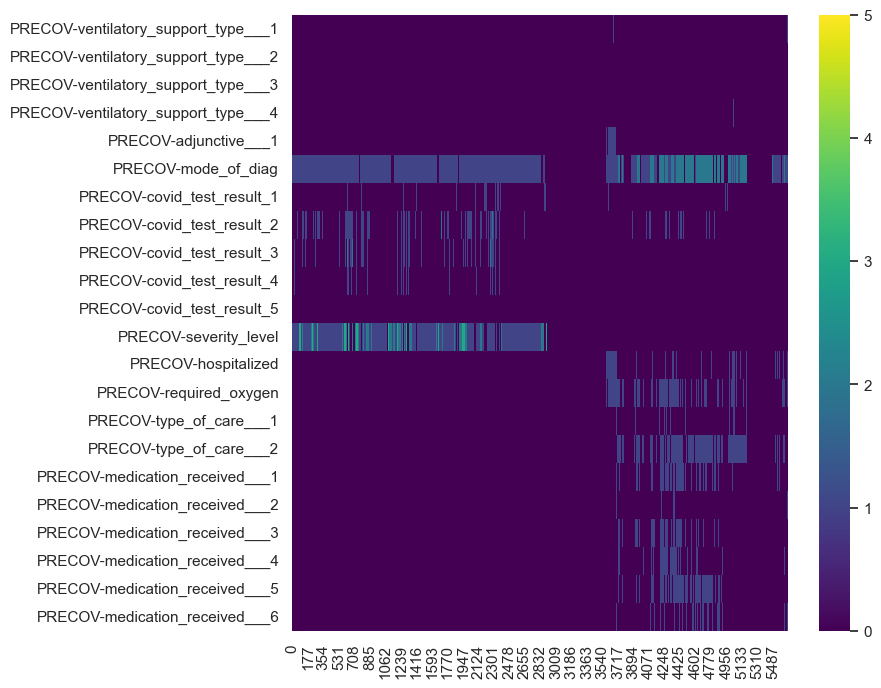

In [350]:
sns.heatmap(precov_features.T, cbar=True, cmap = 'viridis')

## VACCINES

In [351]:
df['vaccinated'].value_counts(dropna=False)

vaccinated
1.0    4383
NaN    1137
0.0     143
Name: count, dtype: int64

In [352]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

#==============================================================================
# use only vaccine status 
# 2024-04-28: confirmed only using VAX status
#==============================================================================
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(5663, 1)


In [353]:
#==============================================================================
# 2024-04-28: deprecate this material below
#==============================================================================

# vvv = pd.concat([df[VAX], df['dag']], axis = 1)
# vl = vvv.groupby('dag').sum().T.sum()
# vl
# pd.concat([vax_features, df['dag']], axis = 1).groupby('dag').sum().T.sum()
# # how many rows with dag = 5?
# vvv.query('dag == 5').shape
# # get a subset of vvv for dag = 5
# vl = vvv.query('dag == 5').head()

# # how many nans per column?
# vl.isnull().sum()

# vl
# # count non-zero values per dag
# vvv.groupby(df['dag']).apply(lambda x: x.astype(bool).sum(axis=0)).rename(index = site_name_dict)

# fig, ax = plt.subplots(figsize=(6,6))

# sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
# plt.title("Vaccination Status - missing values are light coloured")

In [354]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T / df.dag.value_counts().rename(index = site_name_dict)*100

Missing VAX values by site:


dag,LDN,LUS,MTL,RIO,SAN
VAX-vaccinated,49.529781,71.395706,1.407484,0.0,2.064897


In [355]:
#==============================================================================
# 2024-04-28
# In keeping with issues #1, #4, etc., - assume that if it's not reported, it wasn't volunteered by px, nor was it identified by physician/interviewer
# therefore, fill nans with zero
#==============================================================================
vax_features = vax_features.fillna(0)


In [356]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T / df.dag.value_counts().rename(index = site_name_dict)*100

Missing VAX values by site:


dag,LDN,LUS,MTL,RIO,SAN
VAX-vaccinated,0.0,0.0,0.0,0.0,0.0


# SAVE FEATURES TO FILE

In [357]:
# concatenate all of the features
features = pd.concat(
    [
        demographic_features,
        medication_features,
        symptom_features,
        vax_features,
        hx_features_all,
        cd_features,  # NOTE: doesnt include vitals
        cd_NBCD,  # NOTE: this is binarized vitals
        imaging_features,
        func_test_features,
        lab_features_ind,
        substance_features,  # selected by MP for now
        # precov_features,  # selected by DT for now
        # WIP:
        # lab_features, # NOTE: replaced with binarized
        # cd_features, # needs to be revised
        # none
        # NOT SELECTED:
        # survey_features,    # not selected
    ],
    axis=1,
)


features["LC_STATUS"] = df["LC_STATUS"]

print(f"Features Shape: {features.shape}")

Features Shape: (5663, 443)


In [358]:
# precov_special = pd.concat([precov_features, df['dag'], df['LC_STATUS']], axis = 1)
# precov_special.rename(columns={'dag':'SITE'})

# ds = datasets.arrow_dataset.Dataset.from_pandas(precov_special, preserve_index=True)
# ds.save_to_disk(output_path / f"{today}-precov-features.arrow")a

In [359]:
# quality activities
features.columns = features.columns.str.strip()  # ensure columns are clean
features = features.rename(columns={'dag':'SITE'}) #rename dag to 

In [360]:
features.columns

Index(['sex', 'age', 'SITE', 'MED-Analgesics', 'MED-Anesthetics',
       'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants',
       'MED-Antifungals', 'MED-Antimigraine-agents',
       ...
       'LABS-IND-stented', 'LABS-IND-triglycerides', 'LABS-IND-urea',
       'LABS-IND-wbc', 'SUBST-1', 'SUBST-2', 'SUBST-3', 'SUBST-4', 'SUBST-5',
       'LC_STATUS'],
      dtype='object', length=443)

In [371]:
# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# get today's data as a string
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")


# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features, preserve_index=True)
ds.save_to_disk(output_path / f"RECAP-TEST-{today}-features.arrow")

Saving the dataset (0/1 shards):   0%|          | 0/5597 [00:00<?, ? examples/s]

## Additional post-processing

In [372]:
features.columns

Index(['sex', 'age', 'SITE', 'MED-Analgesics', 'MED-Anesthetics',
       'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants',
       'MED-Antifungals', 'MED-Antimigraine-agents',
       ...
       'LABS-IND-sodium', 'LABS-IND-stented', 'LABS-IND-triglycerides',
       'LABS-IND-urea', 'LABS-IND-wbc', 'SUBST-1', 'SUBST-2', 'SUBST-3',
       'SUBST-4', 'SUBST-5'],
      dtype='object', length=442)

In [373]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5597 entries, 0 to 5662
Columns: 442 entries, sex to SUBST-5
dtypes: int64(442)
memory usage: 18.9 MB


In [364]:
# convert bools to int64
features.drop(columns = "LC_STATUS", inplace = True)


# drop any features of type object


features = features.dropna().astype(int)
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5597 entries, 0 to 5662
Columns: 442 entries, sex to SUBST-5
dtypes: int64(442)
memory usage: 18.9 MB


In [365]:
n_rows = features.shape[0]
n_ftrs = features.shape[1]-1

In [366]:
from scipy.stats import chi2_contingency

rf_dict = {}
for col in features.columns:

# make an emtpy dict

# col = "chest_pain___2"
    ct = pd.crosstab(features['SITE'], features[col]).rename(index = site_name_dict)

    result = chi2_contingency(ct)
    if result[1] < 0.05:
        # print(ct)
        print(f"{col}: p = {result[1]}")

        rf_dict[col] = result[1]

rf_df = pd.DataFrame.from_dict(rf_dict, orient = 'index', columns = ['p-value'])
rf_df


sex: p = 3.135934882835992e-13
age: p = 1.1223638265071075e-70
SITE: p = 0.0
MED-Analgesics: p = 1.3969165269158792e-86
MED-Antibacterials: p = 7.017426676214936e-41
MED-Anticonvulsants: p = 0.004576642842633607
MED-Antidepressants: p = 2.9362541097655124e-73
MED-Antifungals: p = 0.007090806239127728
MED-Antimigraine-agents: p = 3.9473100290652206e-10
MED-Antiparasitics: p = 3.7175102124675865e-06
MED-Antiparkinson-agents: p = 0.004576642842633607
MED-Antipsychotics: p = 3.265812680664175e-34
MED-Antispasticity-agents: p = 3.0160963279591565e-06
MED-Antivirals: p = 3.1607321806612065e-38
MED-Blood-glucose-regulators: p = 7.038935497265299e-51
MED-Blood-products: p = 0.00175120952699208
MED-Cardiovascular-agents: p = 7.097769380591227e-265
MED-Dermatological-agents: p = 0.00020190860872218712
MED-Gastrointestinal-agents: p = 8.273465714725174e-31
MED-Hormonal-agents-(sex-hormones): p = 2.3543585921793555e-44
MED-Hormonal-agents-(thyroid): p = 2.4990527614018377e-12
MED-Hormone-suppressa

,p-value
sex,3.135935e-13
age,1.122364e-70
SITE,0.000000e+00
MED-Analgesics,1.396917e-86
MED-Antibacterials,7.017427e-41
...,...
SUBST-1,2.151917e-133
SUBST-2,4.700843e-13
SUBST-3,1.823610e-141
SUBST-4,7.863697e-30


In [367]:
len(rf_df)/n_ftrs

0.6077097505668935

In [368]:
# calculate the mean value of the features by site
mean_by_site = features.groupby('SITE').mean().T

# drop sex and age
mean_by_site = mean_by_site.drop(index = ["sex", "age"])


In [369]:
mean_by_site

SITE,1,2,3,4,5
MED-Analgesics,0.081761,0.000000,0.032448,0.002541,0.112903
MED-Anesthetics,0.000000,0.000000,0.000000,0.000000,0.000806
MED-Antibacterials,0.006289,0.000000,0.014749,0.001271,0.051613
MED-Anticonvulsants,0.003145,0.000000,0.002950,0.000000,0.000000
MED-Antidepressants,0.088050,0.000000,0.017699,0.002541,0.001613
...,...,...,...,...,...
SUBST-1,0.028302,0.244422,0.005900,0.015248,0.016935
SUBST-2,0.040881,0.023344,0.002950,0.000000,0.000000
SUBST-3,0.323899,0.000000,0.067847,0.078780,0.106452
SUBST-4,0.084906,0.058702,0.005900,0.001271,0.001613


<Axes: xlabel='SITE'>

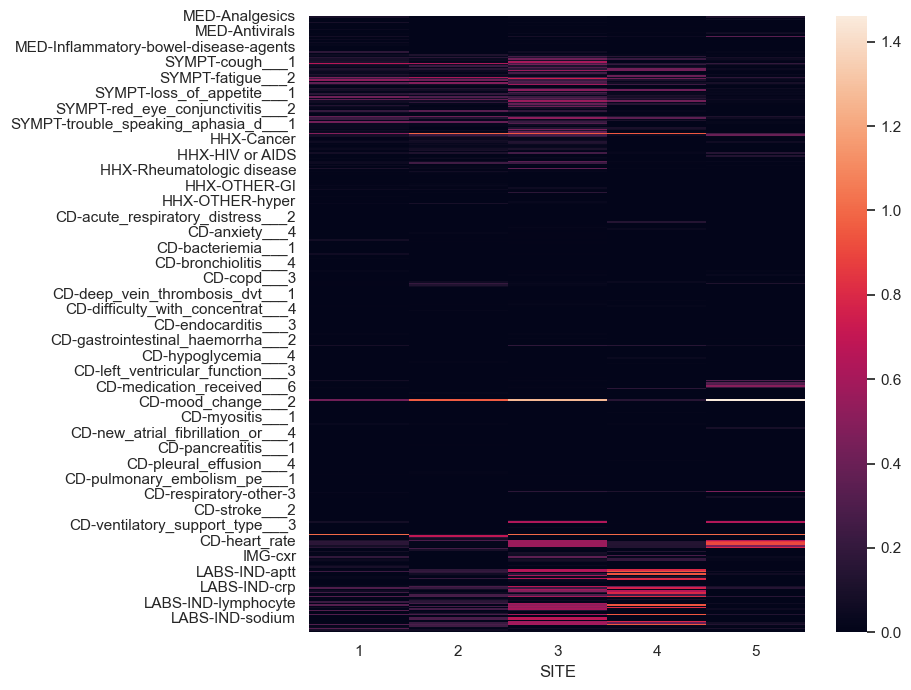

In [370]:
sns.heatmap(mean_by_site)